# Import Libraries

In [7]:
# Upload as zip to Google Colab and unzip
!unzip /content/Dataset.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/Dataset/Train/Clean/e80tdlt-0.png  
  inflating: /content/Dataset/Train/Clean/e842nw3-0.png  
  inflating: /content/Dataset/Train/Clean/e8fxsem-0.png  
  inflating: /content/Dataset/Train/Clean/e8g8rl-0.png  
  inflating: /content/Dataset/Train/Clean/e8jv-0.png  
  inflating: /content/Dataset/Train/Clean/e8log-0.png  
  inflating: /content/Dataset/Train/Clean/e8nq-0.png  
  inflating: /content/Dataset/Train/Clean/e8rnuz-0.png  
  inflating: /content/Dataset/Train/Clean/e8wu2i-0.png  
  inflating: /content/Dataset/Train/Clean/e93v7m-0.png  
  inflating: /content/Dataset/Train/Clean/e949xroz-0.png  
  inflating: /content/Dataset/Train/Clean/e94fa3-0.png  
  inflating: /content/Dataset/Train/Clean/e9adax3-0.png  
  inflating: /content/Dataset/Train/Clean/e9nhvc-0.png  
  inflating: /content/Dataset/Train/Clean/e9qne356-0.png  
  inflating: /content/Dataset/Train/Clean/e9vr550n-0.png  
  inflating: /content/Dataset/Tr

In [2]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

tqdm.pandas()

# Import Dataset

In [15]:
# Create df and labels
folder_path = '/content/Dataset/Train/Clean'
file_list = os.listdir(folder_path)
df = pd.DataFrame(file_list, columns=['file_name'])
df['original_file_path'] = df['file_name'].apply(lambda x: os.path.join(folder_path, x))
df['label'] = df['file_name'].str.split('-0').str[0]

# Show the DataFrame
df = df[0:100]

# Preprocessing / Segmentation

In [16]:
from multiprocessing import Pool

# Cleaning black line noise (can work on optimizing this - use GPU or multiprocessing)
def replace_black_with_surrounding_color(img):
    result = img.copy()

    height, width, _ = img.shape

    for y in range(height):
        for x in range(width):
            if np.array_equal(img[y, x], [0, 0, 0]):
                surrounding_colors = []

                # Loop through the surrounding 8 pixels
                for dy in [-1, 0, 1]:
                    for dx in [-1, 0, 1]:
                        if dy == 0 and dx == 0:
                            continue  # Skip the black pixel itself
                        ny, nx = y + dy, x + dx

                        # Check if the surrounding pixel is within image bounds
                        if 0 <= ny < height and 0 <= nx < width:
                            # Only add non-black surrounding pixels
                            if not np.array_equal(img[ny, nx], [0, 0, 0]):
                                surrounding_colors.append(img[ny, nx])

                # Calculate the average color of the surrounding pixels
                if surrounding_colors:  # Ensure there are surrounding pixels
                    average_color = np.mean(surrounding_colors, axis=0).astype(np.uint8)
                    result[y, x] = average_color  # Replace black pixel with average color

    return result

def process_image(image_path, output_folder):
    # Load the image using OpenCV
    img = cv2.imread(image_path)

    if img is not None:
        # Apply the function to clean the image
        cleaned_image = replace_black_with_surrounding_color(img)

        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

        # Construct the new file path (same filename, different folder)
        output_path = os.path.join(output_folder, os.path.basename(image_path))

        # Save the cleaned image to the new folder
        cv2.imwrite(output_path, cleaned_image)

        return output_path
    else:
        print(f"Error: Could not load image at {image_path}")
        return None

def process_images_in_parallel(image_paths, output_folder):
    with Pool() as pool:
        results = pool.starmap(process_image, [(path, output_folder) for path in image_paths])
    return results

output_folder = "cleaned_images"
df['processed_images'] = process_images_in_parallel(df['original_file_path'].tolist(), output_folder)
df

,file_name,original_file_path,label,processed_images
0,n078j-0.png,/content/Dataset/Train/Clean/n078j-0.png,n078j,cleaned_images/n078j-0.png
1,ugfwgd-0.png,/content/Dataset/Train/Clean/ugfwgd-0.png,ugfwgd,cleaned_images/ugfwgd-0.png
2,c2pt-0.png,/content/Dataset/Train/Clean/c2pt-0.png,c2pt,cleaned_images/c2pt-0.png
3,s34b-0.png,/content/Dataset/Train/Clean/s34b-0.png,s34b,cleaned_images/s34b-0.png
4,mb9v5h-0.png,/content/Dataset/Train/Clean/mb9v5h-0.png,mb9v5h,cleaned_images/mb9v5h-0.png
...,...,...,...,...
95,qaxr3d0d-0.png,/content/Dataset/Train/Clean/qaxr3d0d-0.png,qaxr3d0d,cleaned_images/qaxr3d0d-0.png
96,etzggf7-0.png,/content/Dataset/Train/Clean/etzggf7-0.png,etzggf7,cleaned_images/etzggf7-0.png
97,9bdg86-0.png,/content/Dataset/Train/Clean/9bdg86-0.png,9bdg86,cleaned_images/9bdg86-0.png
98,jlbsqi1-0.png,/content/Dataset/Train/Clean/jlbsqi1-0.png,jlbsqi1,cleaned_images/jlbsqi1-0.png


# Method 1: Contouring

In [35]:
# Function to process images and extract ROIs
output_char_folder = "extracted_chars"
if not os.path.exists(output_char_folder):
    os.makedirs(output_char_folder)
contour_too_small_threshold = 8

def extract_rois(image_path):
    # Load the processed image
    img = cv2.imread(image_path)

    if img is not None:
        # Convert to grayscale and threshold
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 254, 255, cv2.THRESH_BINARY_INV)

        # Find contours
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        img_with_contours = img.copy()
        cv2.drawContours(img_with_contours, contours, -1, (0, 255, 75), 2)

        # Sort contours from left to right
        sorted_contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

        rois = []  # List to store ROIs for display later
        for contour in sorted_contours:
            x, y, w, h = cv2.boundingRect(contour)
            if w <= contour_too_small_threshold and h <= contour_too_small_threshold:
                continue

            # Draw bounding box on the image (optional)
            cv2.rectangle(img_with_contours, (x, y), (x + w, y + h), (36, 255, 12), 2)

            # Extract ROI and store it TESTINGGGGGG
            ROI = img[y:y+h, x:x+w]

            # Padding and resizing
            if w > h:
                # Add padding to the top and bottom
                pad_top = (w - h) // 2
                pad_bottom = w - h - pad_top
                ROI_padded = cv2.copyMakeBorder(ROI, pad_top, pad_bottom, 0, 0, cv2.BORDER_CONSTANT, value=(255, 255, 255))
            else:
                # Add padding to the left and right
                pad_left = (h - w) // 2
                pad_right = h - w - pad_left
                ROI_padded = cv2.copyMakeBorder(ROI, 0, 0, pad_left, pad_right, cv2.BORDER_CONSTANT, value=(255, 255, 255))

            resized_ROI = cv2.resize(ROI_padded, (32, 32))
            rois.append(resized_ROI)

        return img_with_contours, rois  # Return both the image with contours and ROIs
    else:
        print(f"Error: Could not load image at {image_path}")
        return None, []

# Apply the ROI extraction to processed images in the DataFrame
df['rois'] = df['processed_images'].progress_apply(lambda path: extract_rois(path))

# Display results
# for index, (contours_image, rois) in enumerate(zip(df['rois'].apply(lambda x: x[0]), df['rois'].apply(lambda x: x[1]))):
#     plt.figure(figsize=(10, 5))

#     # Display image with bounding boxes
#     plt.subplot(1, 2, 1)
#     plt.imshow(cv2.cvtColor(contours_image, cv2.COLOR_BGR2RGB))
#     plt.title("Image with Contours")
#     plt.axis('off')

#     # Display ROIs
#     plt.subplot(1, 2, 2)
#     for i, roi in enumerate(rois):
#         plt.subplot(1, len(rois), i + 1)
#         plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
#         plt.title(f"CHAR {i + 1}")
#         plt.axis('off')

#     plt.show()


100%|██████████| 100/100 [00:00<00:00, 1099.73it/s]


In [36]:
df

,file_name,original_file_path,label,processed_images,rois
0,n078j-0.png,/content/Dataset/Train/Clean/n078j-0.png,n078j,cleaned_images/n078j-0.png,"([[[255 255 255], [255 255 255], [255 255 255]..."
1,ugfwgd-0.png,/content/Dataset/Train/Clean/ugfwgd-0.png,ugfwgd,cleaned_images/ugfwgd-0.png,"([[[255 255 255], [255 255 255], [255 255 255]..."
2,c2pt-0.png,/content/Dataset/Train/Clean/c2pt-0.png,c2pt,cleaned_images/c2pt-0.png,"([[[255 255 255], [255 255 255], [255 255 255]..."
3,s34b-0.png,/content/Dataset/Train/Clean/s34b-0.png,s34b,cleaned_images/s34b-0.png,"([[[255 255 255], [255 255 255], [255 255 255]..."
4,mb9v5h-0.png,/content/Dataset/Train/Clean/mb9v5h-0.png,mb9v5h,cleaned_images/mb9v5h-0.png,"([[[255 255 255], [255 255 255], [255 255 255]..."
...,...,...,...,...,...
95,qaxr3d0d-0.png,/content/Dataset/Train/Clean/qaxr3d0d-0.png,qaxr3d0d,cleaned_images/qaxr3d0d-0.png,"([[[255 255 255], [255 255 255], [255 255 255]..."
96,etzggf7-0.png,/content/Dataset/Train/Clean/etzggf7-0.png,etzggf7,cleaned_images/etzggf7-0.png,"([[[255 255 255], [255 255 255], [255 255 255]..."
97,9bdg86-0.png,/content/Dataset/Train/Clean/9bdg86-0.png,9bdg86,cleaned_images/9bdg86-0.png,"([[[255 255 255], [255 255 255], [255 255 255]..."
98,jlbsqi1-0.png,/content/Dataset/Train/Clean/jlbsqi1-0.png,jlbsqi1,cleaned_images/jlbsqi1-0.png,"([[[255 255 255], [255 255 255], [255 255 255]..."


-----POTENTIAL MISMATCH-----
Mismatch for cleaned_images/s8fq-0.png: 2 ROIs but label length is 4.
Mismatch for cleaned_images/q9k0po8-0.png: 6 ROIs but label length is 7.
Mismatch for cleaned_images/t73j19vi-0.png: 6 ROIs but label length is 8.
Mismatch for cleaned_images/5n95t-0.png: 4 ROIs but label length is 5.
Mismatch for cleaned_images/ckp24c3b-0.png: 2 ROIs but label length is 8.
Mismatch for cleaned_images/mk7t1nl4-0.png: 4 ROIs but label length is 8.
Mismatch for cleaned_images/f9305osy-0.png: 14 ROIs but label length is 8.
Mismatch for cleaned_images/u5zba0-0.png: 5 ROIs but label length is 6.
TOTAL MISMATCH COUNT: 8
Displaying mismatched images:


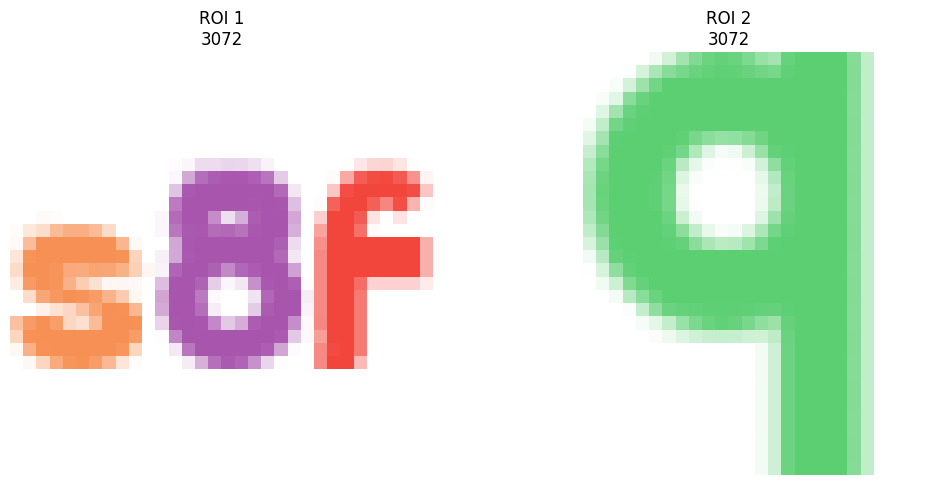

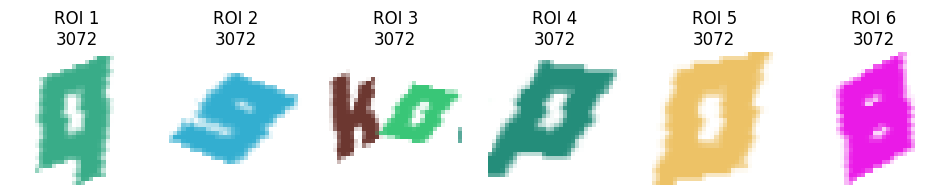

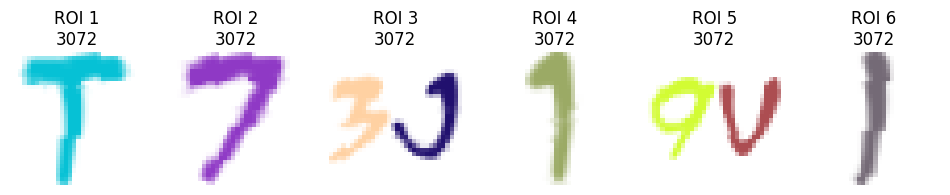

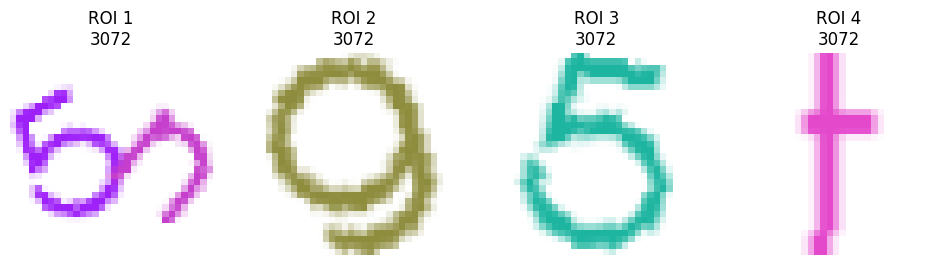

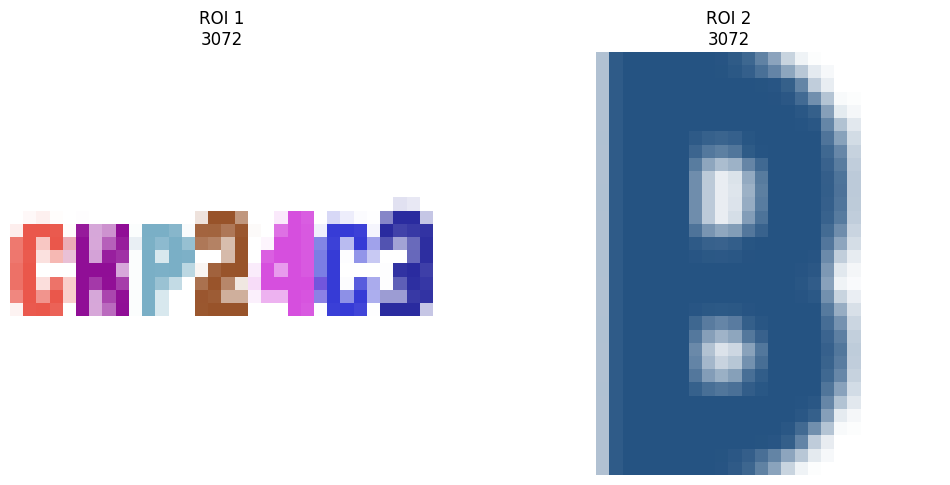

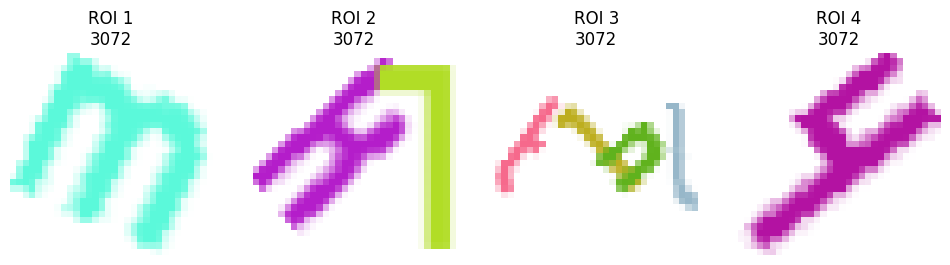

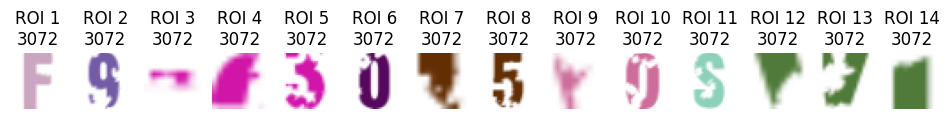

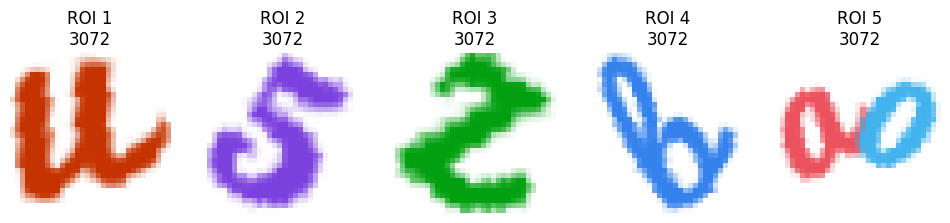

In [37]:
# Create a directory for saving character images if it doesn't exist
output_char_folder = "extracted_chars"
if not os.path.exists(output_char_folder):
    os.makedirs(output_char_folder)

mismatch_count = 0
mismatched_images = []  # To store mismatched images for display


# Function to save ROIs if the count matches the label length
def save_rois_if_match(image_path, label, rois):
    global mismatch_count  # Declare mismatch_count as global
    # Check if number of ROIs matches the length of the label
    if len(rois) == len(label):
        saved_paths = []
        for i, roi in enumerate(rois):
            # Construct the file name and save the ROI
            roi_file_name = f"{os.path.basename(image_path).split('.')[0]}_char_{i + 1}.png"
            roi_path = os.path.join(output_char_folder, roi_file_name)
            cv2.imwrite(roi_path, roi)
            saved_paths.append(roi_path)
        return saved_paths
    else:
        print(f"Mismatch for {image_path}: {len(rois)} ROIs but label length is {len(label)}.")
        mismatch_count += 1
        mismatched_images.append((image_path, rois))
        return []

# Creating a new DataFrame to store saved image paths
saved_images_data = []

# Iterate through the DataFrame to process each image
print('-----POTENTIAL MISMATCH-----')
for idx, row in df.iterrows():
    image_path = row['processed_images']
    label = row['label']  # Assuming you have a 'label' column in the DataFrame
    contours_image, rois = extract_rois(image_path)

    # Save ROIs if they match the label length
    saved_paths = save_rois_if_match(image_path, label, rois)

    # Append the results to the new DataFrame
    if saved_paths:
        saved_images_data.append({
            'image_path': image_path,
            'label': label,
            'saved_char_paths': saved_paths
        })

print(f'TOTAL MISMATCH COUNT: {mismatch_count}')
if mismatched_images:
    print("Displaying mismatched images:")
    for image_path, rois in mismatched_images:
        img = cv2.imread(image_path)
        if img is not None:
            if rois:
                plt.figure(figsize=(12, 6))
                for i, roi in enumerate(rois):
                    plt.subplot(1, len(rois), i + 1)
                    plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
                    plt.title(f"ROI {i + 1}\n{roi.size}")
                    plt.axis('off')
                plt.show()
        else:
            print(f"Could not load image: {image_path}")

In [38]:
saved_images_df = pd.DataFrame(saved_images_data)
saved_images_df

,image_path,label,saved_char_paths
0,cleaned_images/n078j-0.png,n078j,"[extracted_chars/n078j-0_char_1.png, extracted..."
1,cleaned_images/ugfwgd-0.png,ugfwgd,"[extracted_chars/ugfwgd-0_char_1.png, extracte..."
2,cleaned_images/c2pt-0.png,c2pt,"[extracted_chars/c2pt-0_char_1.png, extracted_..."
3,cleaned_images/s34b-0.png,s34b,"[extracted_chars/s34b-0_char_1.png, extracted_..."
4,cleaned_images/mb9v5h-0.png,mb9v5h,"[extracted_chars/mb9v5h-0_char_1.png, extracte..."
...,...,...,...
87,cleaned_images/qaxr3d0d-0.png,qaxr3d0d,"[extracted_chars/qaxr3d0d-0_char_1.png, extrac..."
88,cleaned_images/etzggf7-0.png,etzggf7,"[extracted_chars/etzggf7-0_char_1.png, extract..."
89,cleaned_images/9bdg86-0.png,9bdg86,"[extracted_chars/9bdg86-0_char_1.png, extracte..."
90,cleaned_images/jlbsqi1-0.png,jlbsqi1,"[extracted_chars/jlbsqi1-0_char_1.png, extract..."


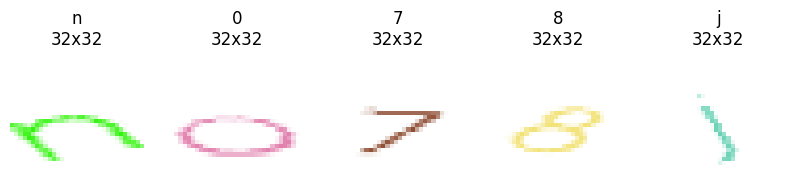

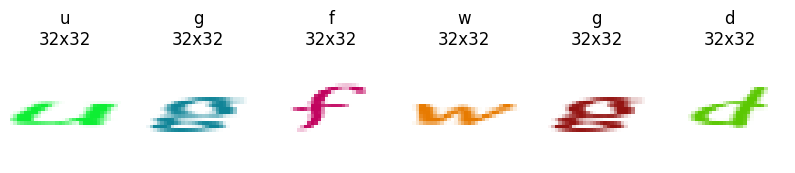

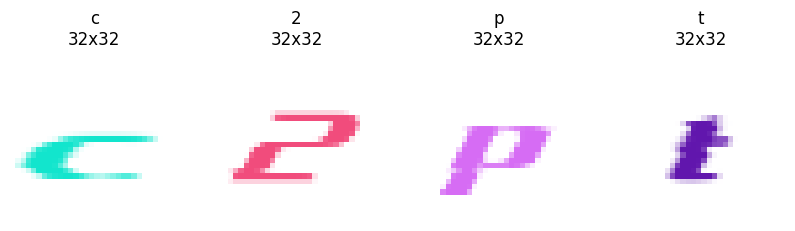

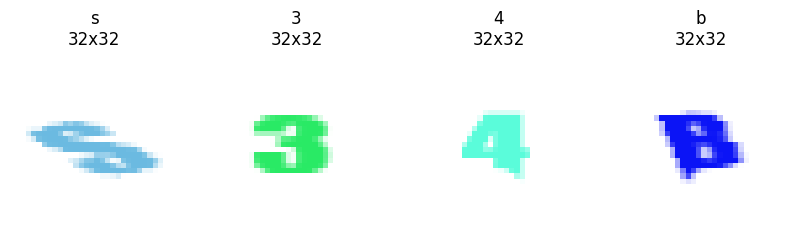

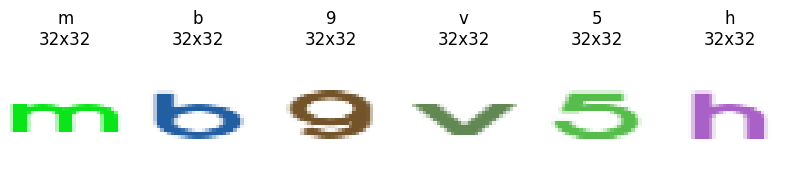

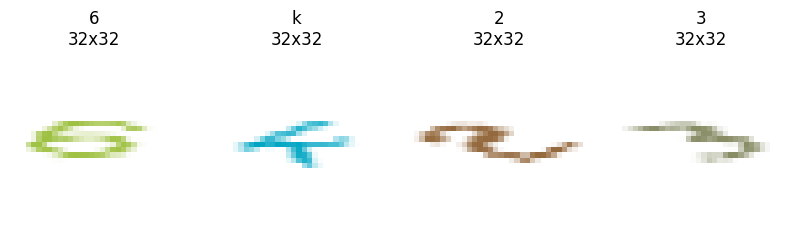

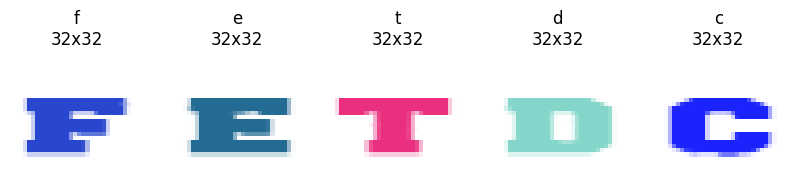

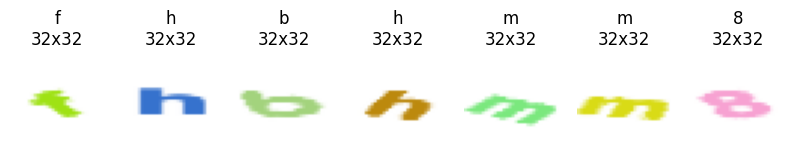

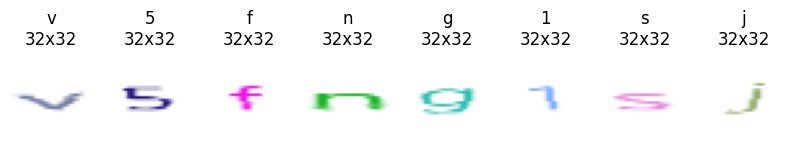

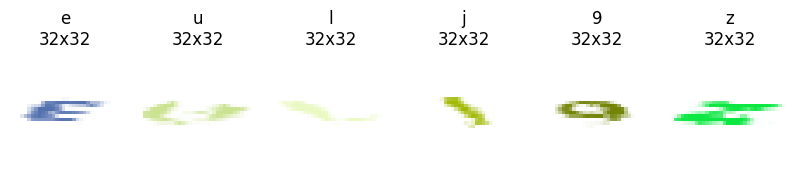

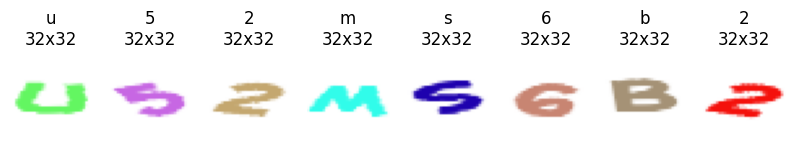

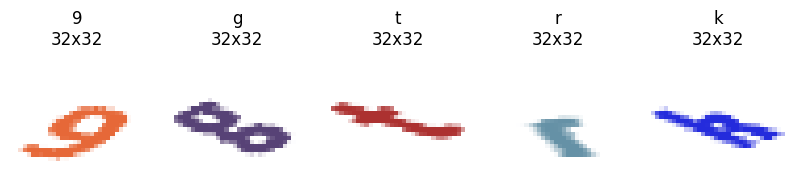

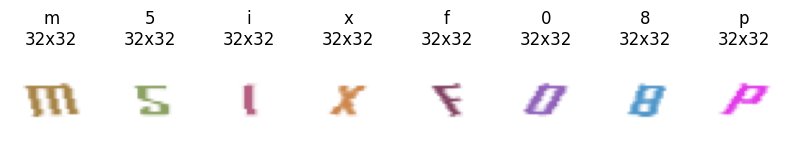

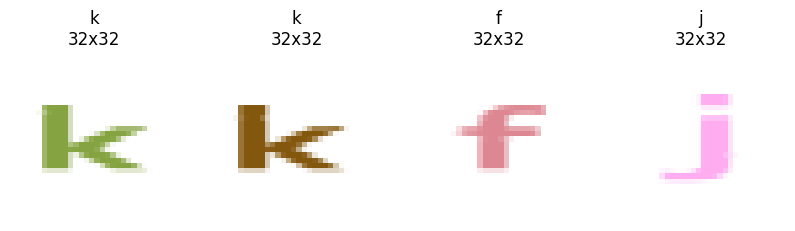

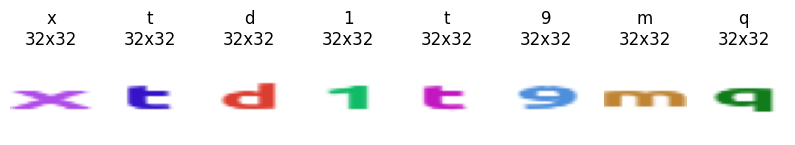

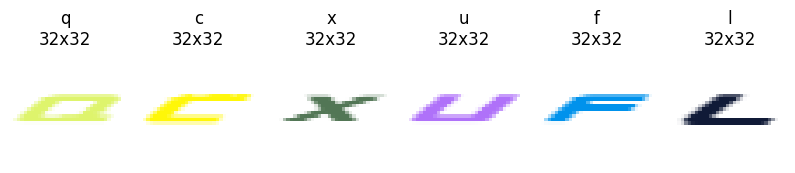

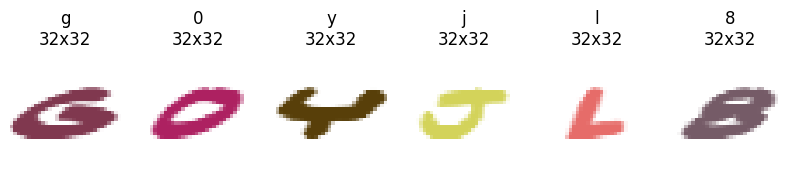

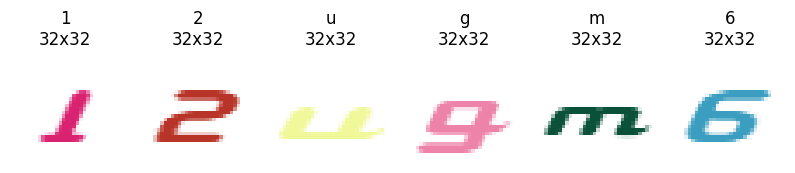

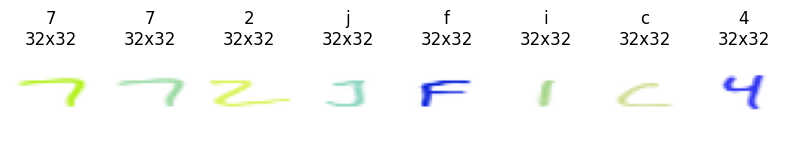

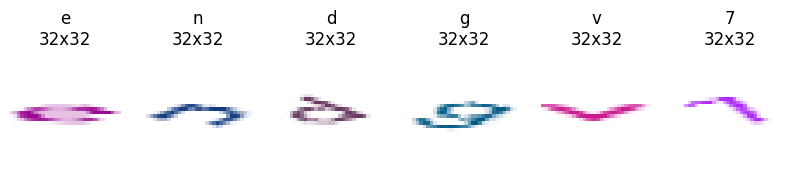

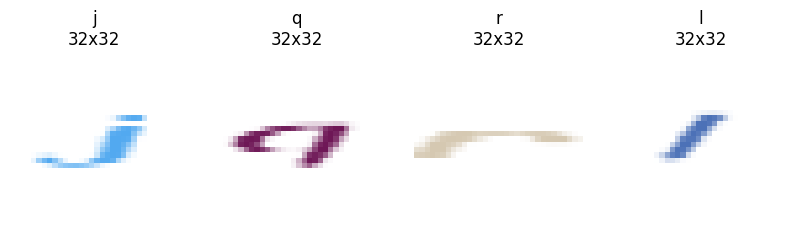

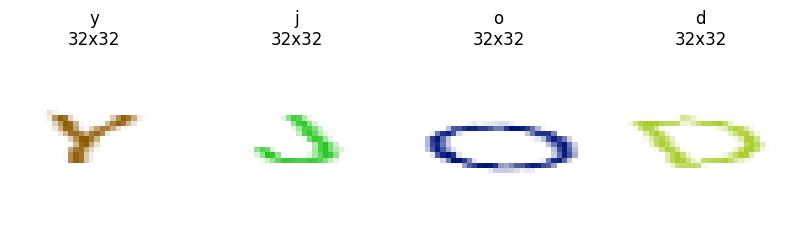

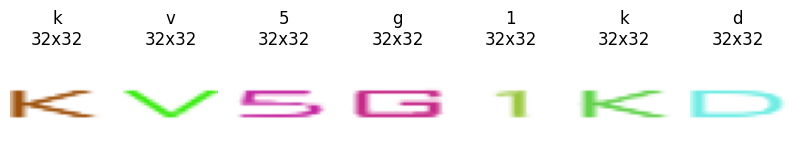

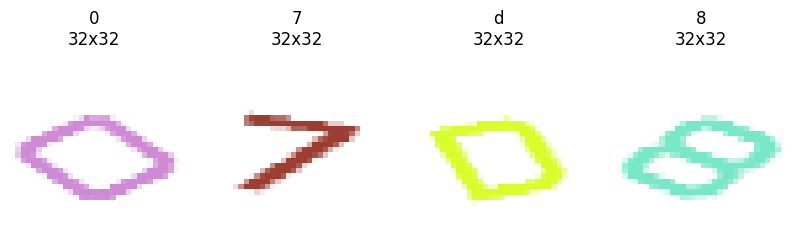

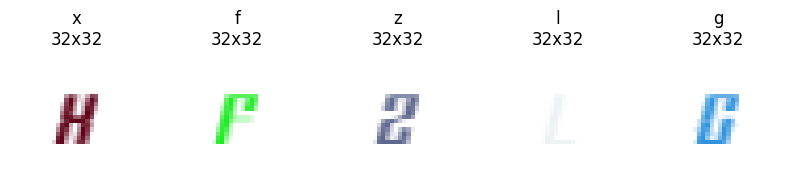

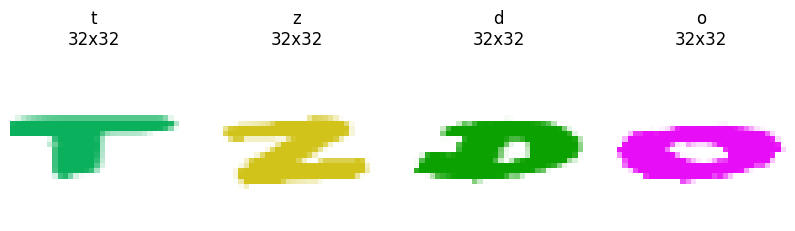

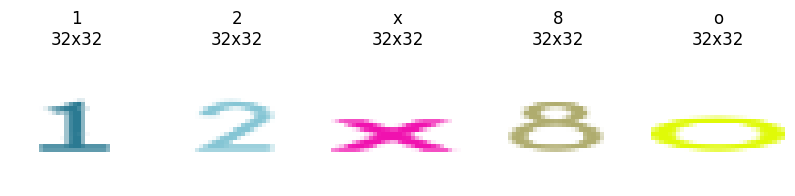

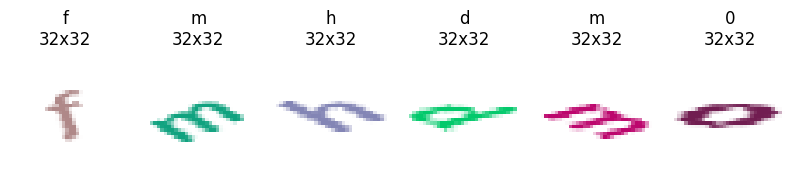

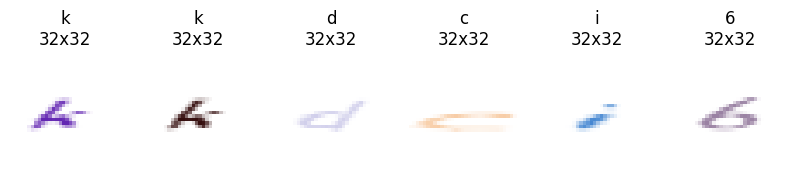

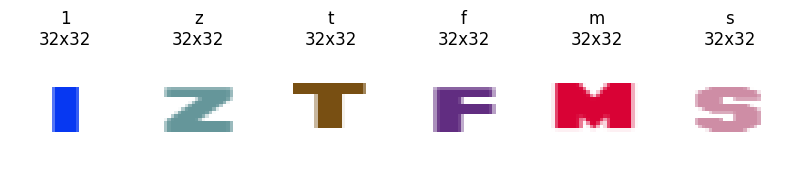

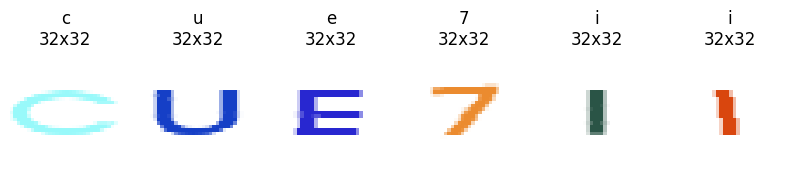

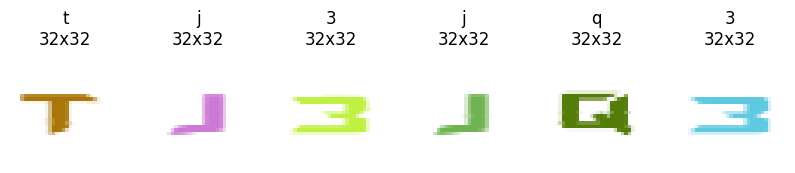

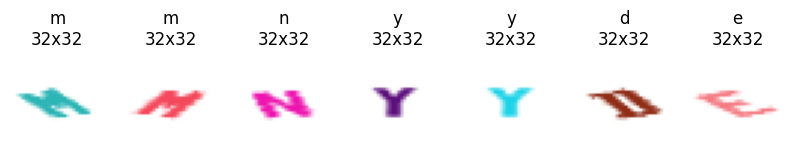

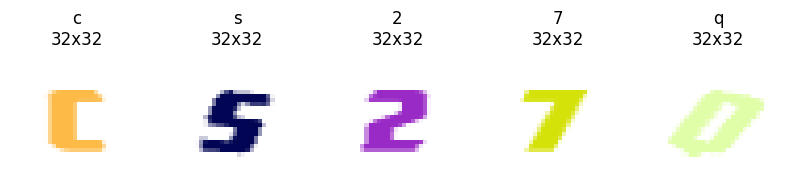

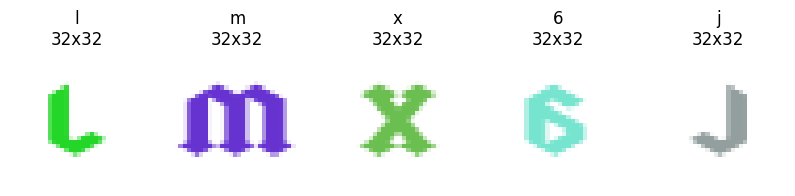

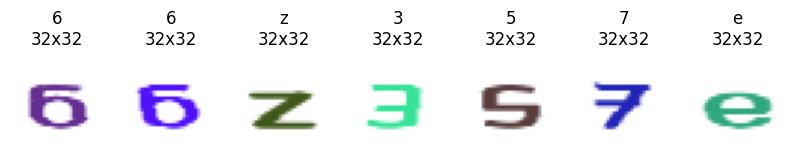

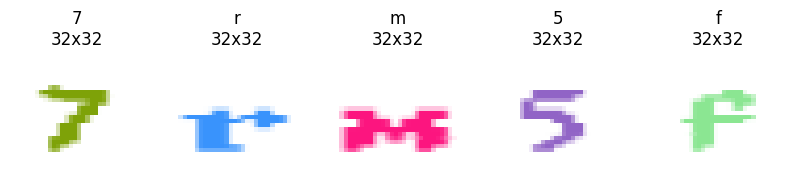

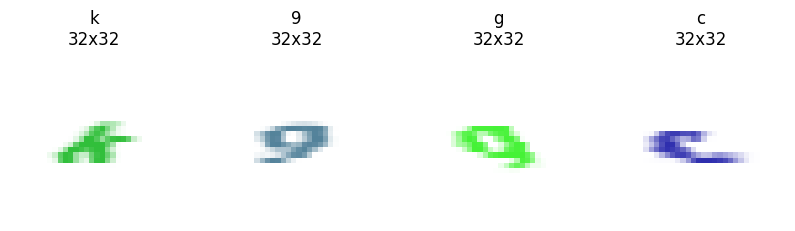

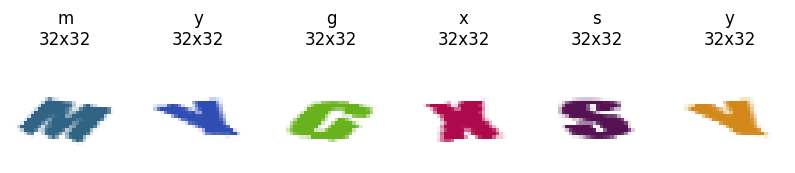

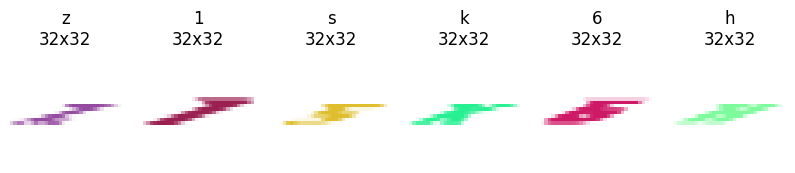

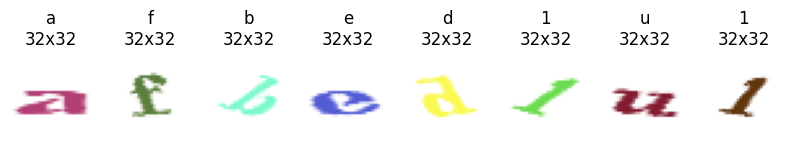

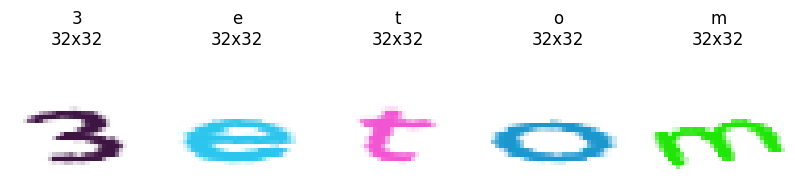

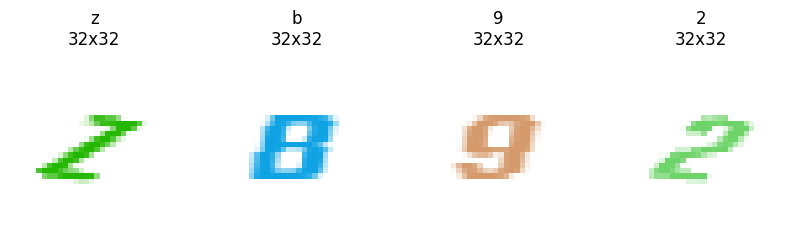

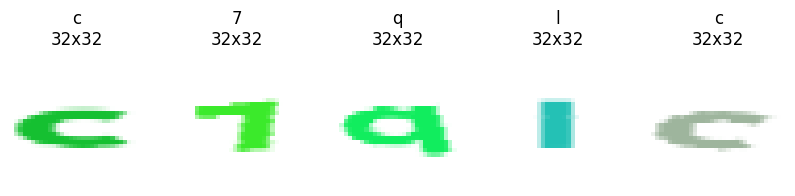

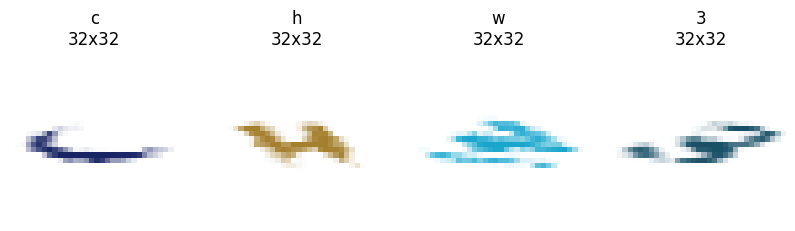

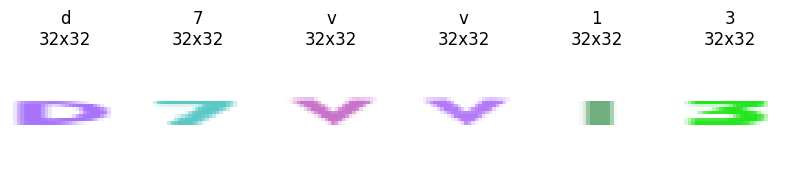

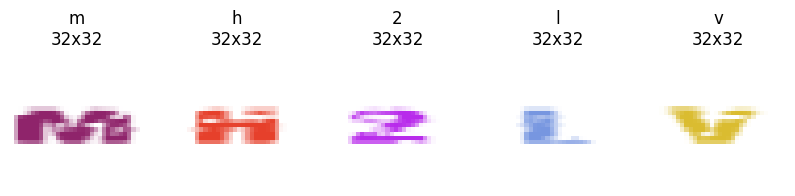

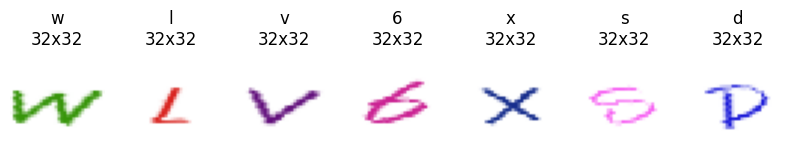

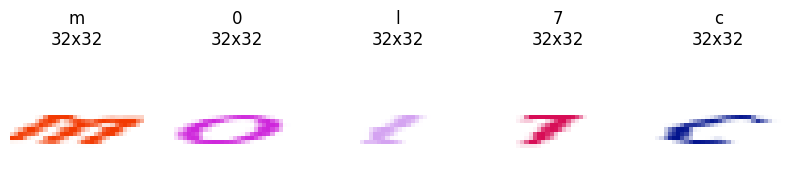

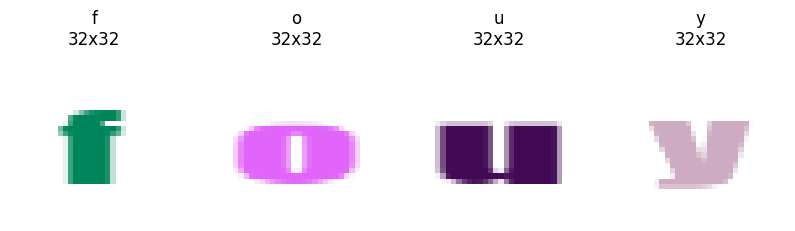

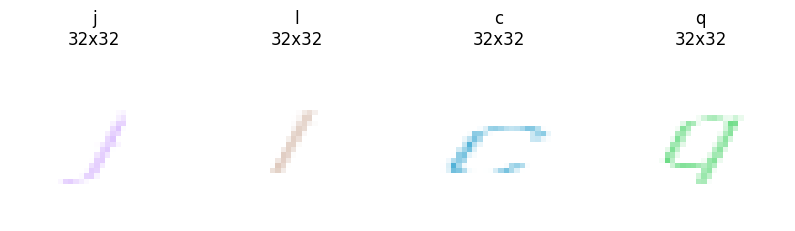

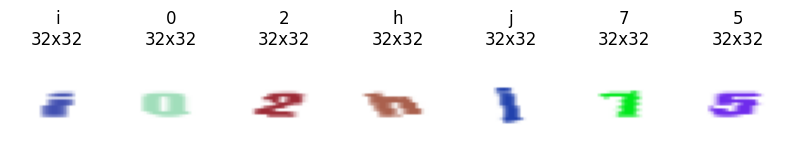

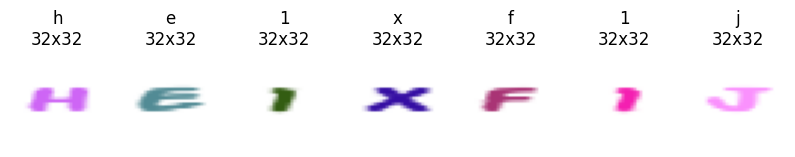

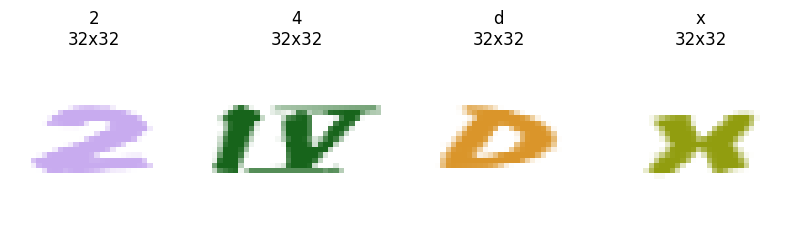

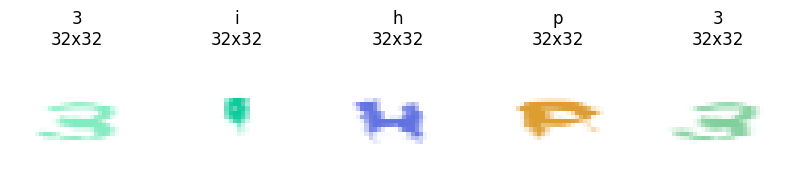

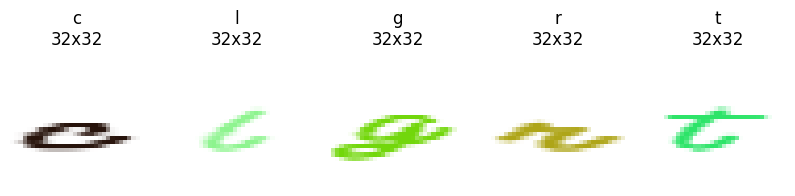

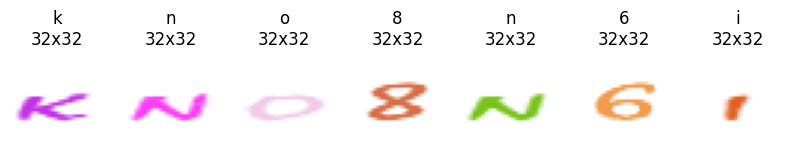

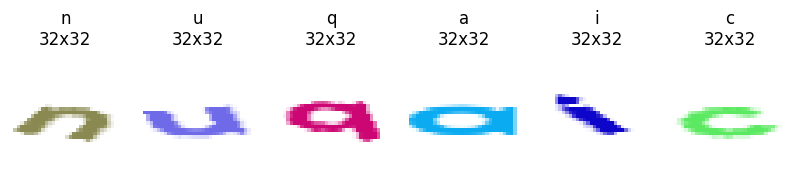

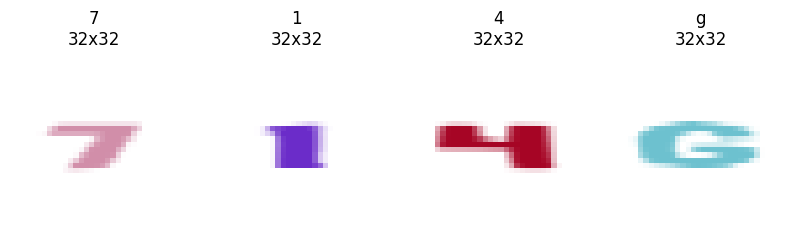

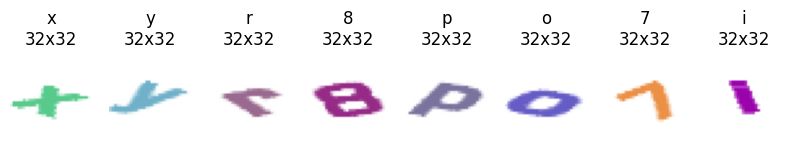

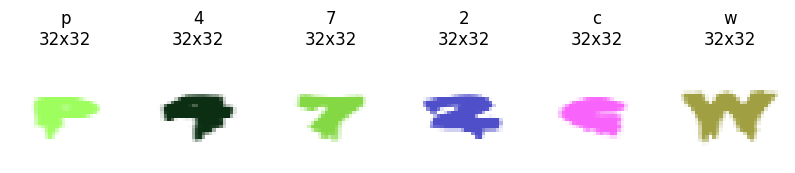

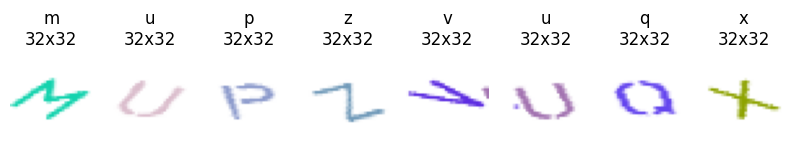

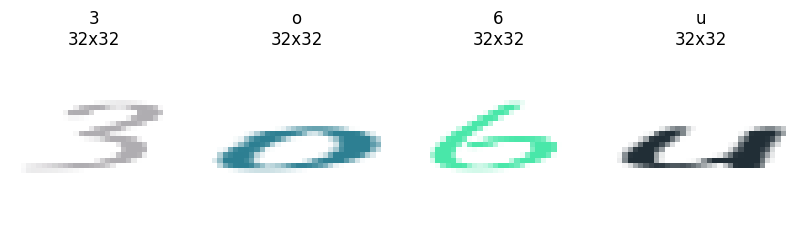

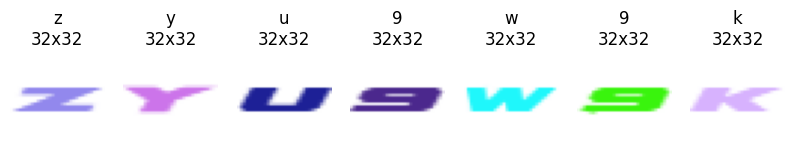

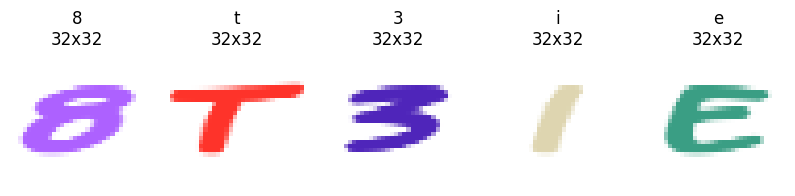

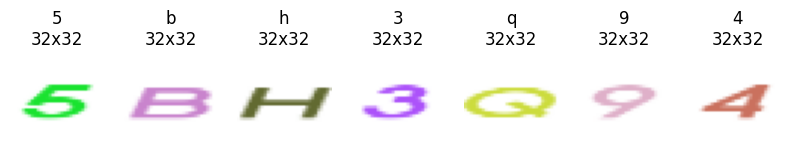

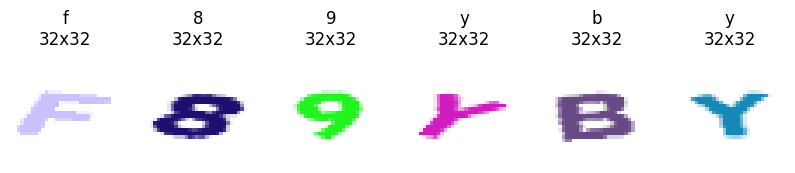

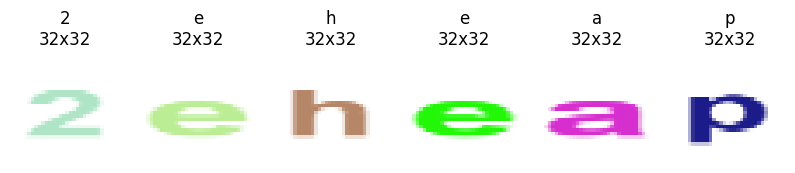

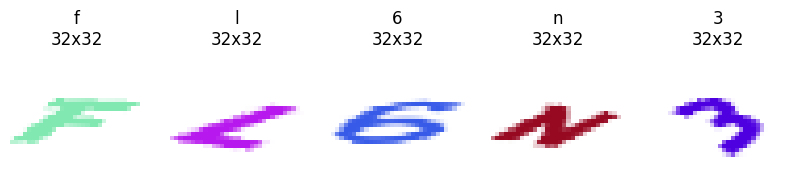

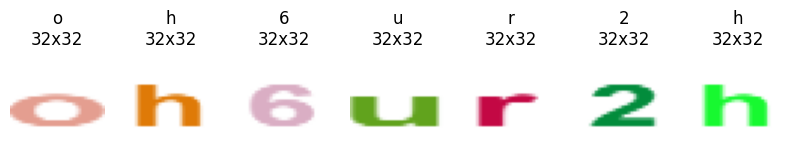

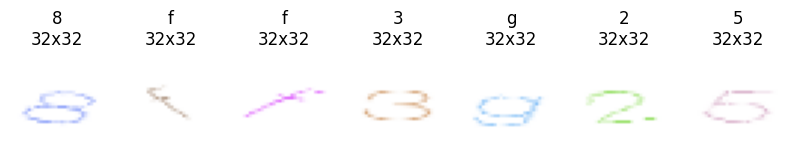

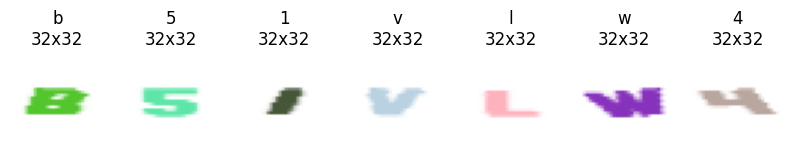

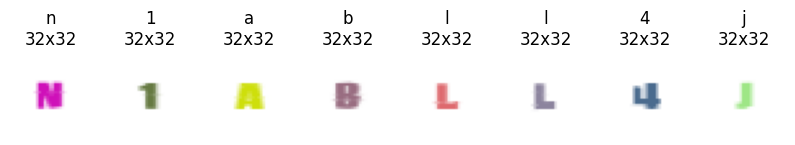

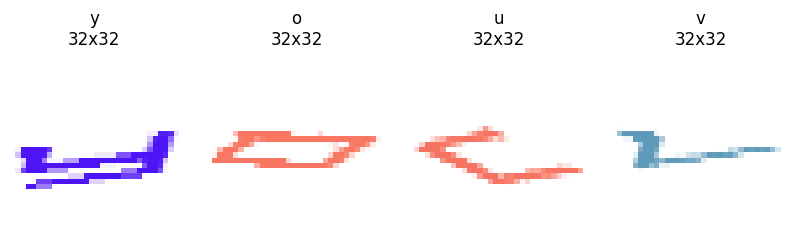

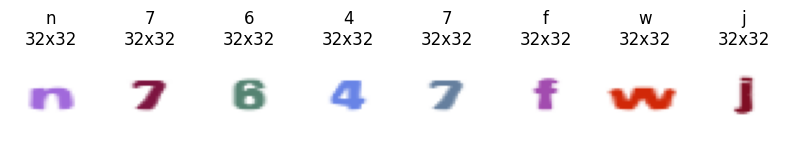

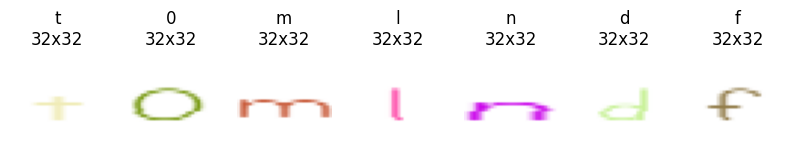

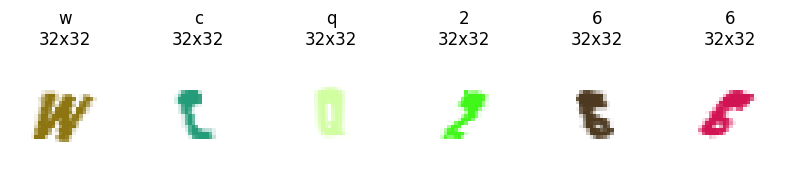

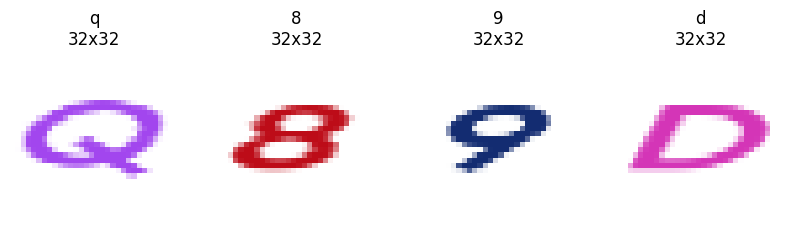

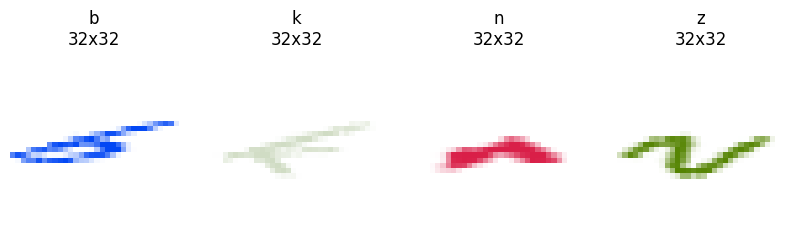

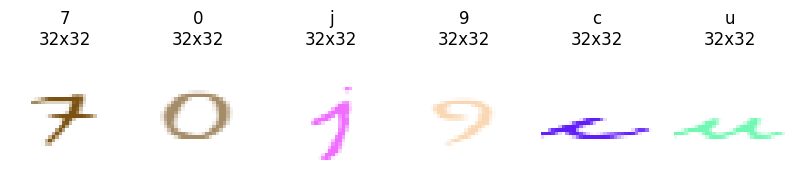

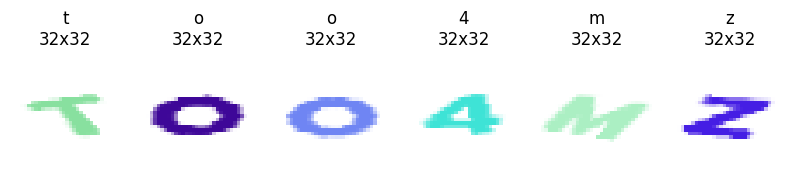

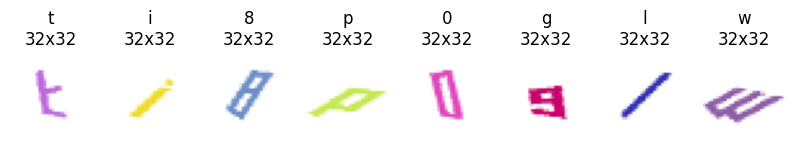

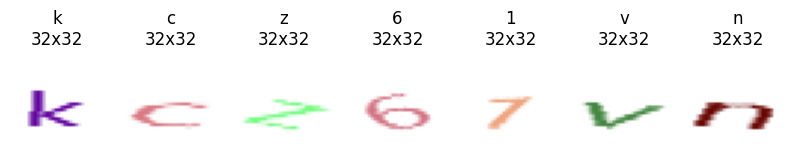

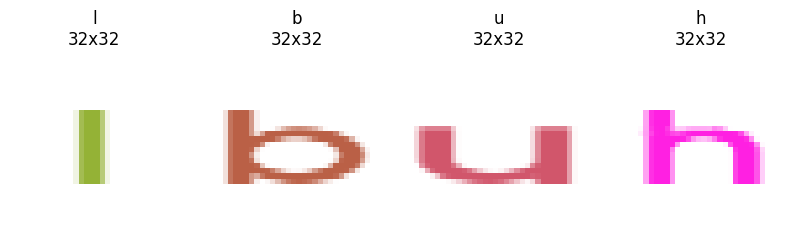

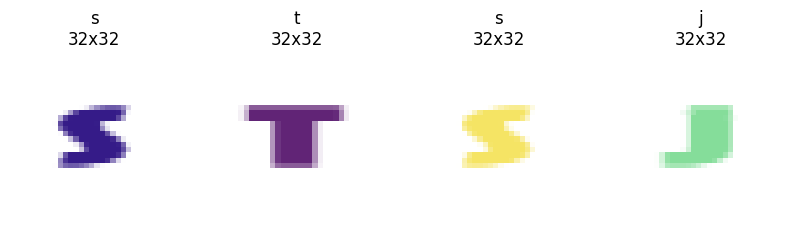

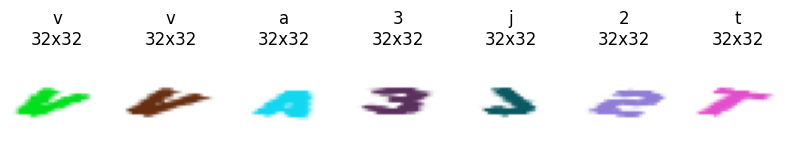

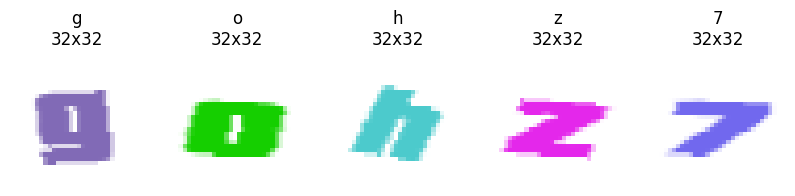

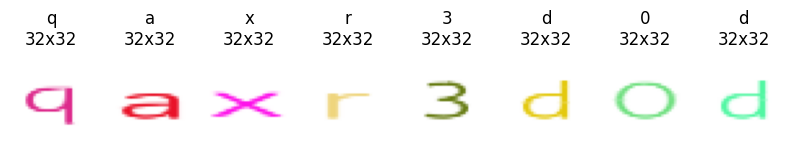

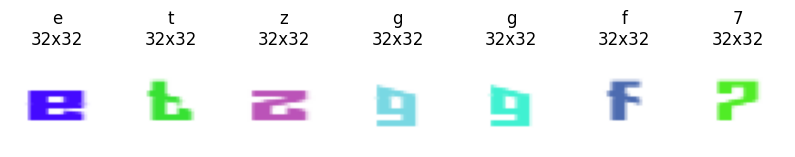

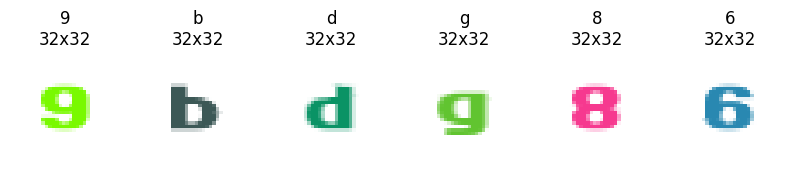

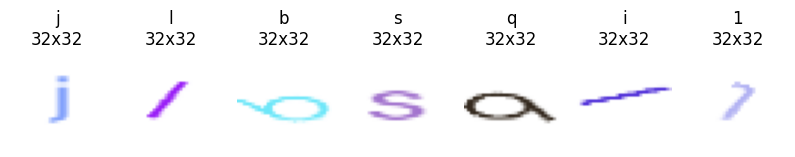

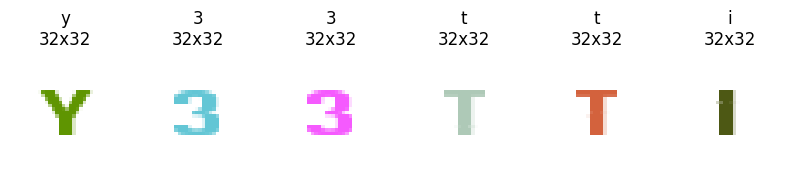

In [34]:
from PIL import Image

# Sanity check (see if cropped )
def print_image_size(image_path):
    # Open the image using PIL
    with Image.open(image_path) as img:
        # Get image dimensions
        width, height = img.size
        return f"{width}x{height}"

for _, row in saved_images_df.iterrows():
    plt.figure(figsize=(10, 5))
    for i, char_path in enumerate(row['saved_char_paths']):
        plt.subplot(1, len(row['saved_char_paths']), i + 1)
        plt.imshow(cv2.cvtColor(cv2.imread(char_path), cv2.COLOR_BGR2RGB))
        plt.title(f"{row['label'][i]}\n{print_image_size(row['saved_char_paths'][i])}")  # Use the actual character from the label
        plt.axis('off')
    plt.show()


In [ ]:
# Handle mismatched images
def quantize_colors(image, n_colors=12):
    """ Reduce the number of colors in the image using K-means clustering. """
    # Reshape the image to a 2D array of pixels
    pixels = image.reshape(-1, 3)

    # Convert to float for K-means
    pixels = np.float32(pixels)

    # Define criteria and apply K-means
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(pixels, n_colors, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Convert centers to uint8
    centers = np.uint8(centers)

    # Map the labels to the quantized colors
    quantized_image = centers[labels.flatten()]
    quantized_image = quantized_image.reshape(image.shape)

    return quantized_image

def get_frequent_colors_with_threshold(image, threshold_ratio=0.5, n_colors=12):
    # Reduce the color range of the image
    image = quantize_colors(image, n_colors)
    plt.imshow(image)

    # Convert the image from BGR to RGB format
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Step 2: Reshape the image to a 2D array of pixels
    pixels = image_rgb.reshape(-1, 3)

    # Step 3: Filter out white pixels (where RGB is [255, 255, 255])
    non_white_pixels = [tuple(pixel) for pixel in pixels if not (np.all(pixel == [254, 254, 254]) or np.all(pixel == [0, 0, 0]))]

    # Step 4: Count the frequency of each unique color (as tuples)
    color_counts = Counter(non_white_pixels)

    # Step 5: Find the most frequent color and its frequency
    most_common_color, max_frequency = color_counts.most_common(1)[0]

    # Step 6: Apply a threshold relative to the frequency of the most common color
    threshold = max_frequency * threshold_ratio

    # Filter out colors that occur less frequently than the threshold
    frequent_colors = {color: freq for color, freq in color_counts.items() if freq >= threshold}

    # Step 7: Display the most frequent colors
    print(f"Most frequent color: {most_common_color} with frequency {max_frequency}")
    print(f"Threshold: {threshold}")
    print("Frequent colors (above threshold):")
    for color, freq in frequent_colors.items():
        print(f"Color: {color}, Frequency: {freq}")

    # Step 8: Plot the histogram of frequent colors
    colors = np.array(list(frequent_colors.keys()))
    frequencies = np.array(list(frequent_colors.values()))

    # Normalize the color values to [0, 1] for displaying in matplotlib
    normalized_colors = colors / 255.0

    # Plot the histogram
    plt.figure(figsize=(12, 8))
    plt.bar(range(len(frequencies)), frequencies, color=normalized_colors, width=1.0)

    # Configure plot
    plt.title(f'Frequent Colors Above {threshold_ratio*100:.0f}% of the Most Common Color')
    plt.xlabel('Unique Colors')
    plt.ylabel('Frequency')
    plt.xticks([])  # Remove x-axis ticks to focus on color distribution
    plt.grid()

    # Show the plot
    plt.show()

    return frequent_colors, image_rgb

# Example usage
frequent_colors, processed_image = get_frequent_colors_with_threshold(img, threshold_ratio=0.2, n_colors=12)

for image_path, rois in mismatched_images:
    print(image_path)

cleaned_images/cdoggjxn-0.png
cleaned_images/28rqld-0.png
cleaned_images/dkquuyly-0.png


In [ ]:
# Create a new DataFrame with saved images
char_images_data = []

# Iterate through each saved image entry
for entry in saved_images_data:
    image_path = entry['image_path']
    label = entry['label']
    saved_char_paths = entry['saved_char_paths']

    # Create a new entry for each character
    for i, char_path in enumerate(saved_char_paths):
        char_images_data.append({
            'char_image_path': char_path,
            'label': label[i],  # Get the corresponding character label
            'original_image_path': image_path
        })

# Create the DataFrame from the character images data
character_df = pd.DataFrame(char_images_data)
character_df

,char_image_path,label,original_image_path
0,extracted_chars/q8l04ku-0_char_1.png,q,cleaned_images/q8l04ku-0.png
1,extracted_chars/q8l04ku-0_char_2.png,8,cleaned_images/q8l04ku-0.png
2,extracted_chars/q8l04ku-0_char_3.png,l,cleaned_images/q8l04ku-0.png
3,extracted_chars/q8l04ku-0_char_4.png,0,cleaned_images/q8l04ku-0.png
4,extracted_chars/q8l04ku-0_char_5.png,4,cleaned_images/q8l04ku-0.png
...,...,...,...
94,extracted_chars/oukcv15-0_char_3.png,k,cleaned_images/oukcv15-0.png
95,extracted_chars/oukcv15-0_char_4.png,c,cleaned_images/oukcv15-0.png
96,extracted_chars/oukcv15-0_char_5.png,v,cleaned_images/oukcv15-0.png
97,extracted_chars/oukcv15-0_char_6.png,1,cleaned_images/oukcv15-0.png


# Method 2: Brisk Algorithm

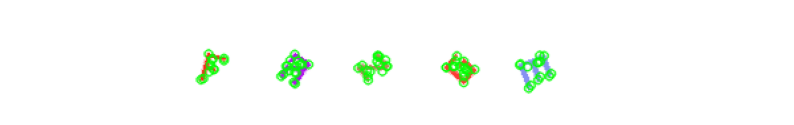

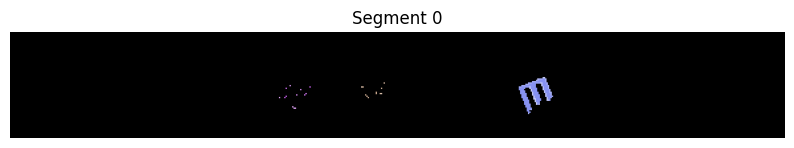

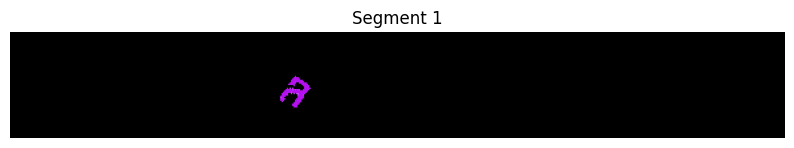

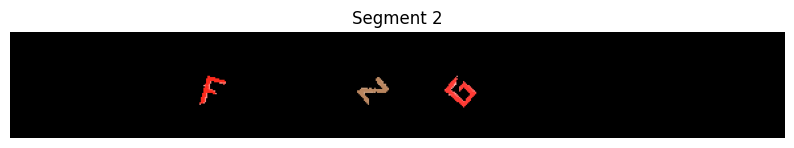

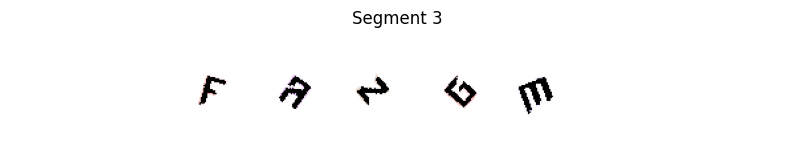

In [ ]:
def getDes(Im, tool, data_dir):
    # Initialize the feature detector based on the selected tool
    if tool == 'BRISK':
        source = cv2.BRISK_create()
    else:
        raise ValueError("Unsupported tool: only 'BRISK' is supported.")

    # Check if the image file ends with .png
    if Im.endswith('.png'):
        # Load the image
        img_path = os.path.join(data_dir, Im)
        img = cv2.imread(img_path)

        if img is not None:
            # Detect keypoints and compute descriptors
            kp, des = source.detectAndCompute(img, None)

            # Draw keypoints on the image
            imgKP = cv2.drawKeypoints(img, kp, None, color=(0, 255, 0), flags=0)

            # Display the image with keypoints
            plt.figure(figsize=(10, 10))
            plt.axis('off')
            plt.imshow(cv2.cvtColor(imgKP, cv2.COLOR_BGR2RGB))
            plt.show()

            # Perform image segmentation
            segment_images(img, k=4, base_name=Im.split('.')[0])
            return des
        else:
            print(f"Error: Could not load image at {img_path}.")
            return None
    else:
        print("Error: The image file must be a PNG file.")
        return None

def segment_images(img, k=4, base_name="segment"):
    # Reshape the image to be a list of pixels
    pixel_values = img.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)

    # Define criteria and apply KMeans
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Convert back to 8 bit values
    centers = np.uint8(centers)

    # Map labels to center colors
    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape(img.shape)

    # Save each segment as a separate image
    for i in range(k):
        # Create a mask for each cluster
        mask = (labels == i).reshape(img.shape[:2]).astype(np.uint8)
        segmented_cluster = cv2.bitwise_and(img, img, mask=mask)

        # Save the segmented image
        cluster_image_name = f"{base_name}_segment_{i}.png"
        cv2.imwrite(cluster_image_name, segmented_cluster)

        # Display the segmented cluster
        plt.figure(figsize=(10, 10))
        plt.axis('off')
        plt.imshow(cv2.cvtColor(segmented_cluster, cv2.COLOR_BGR2RGB))
        plt.title(f"Segment {i}")
        plt.show()

data_dir = "/content/cleaned_images/"
image_name = "fazgm-0.png"
descriptors = getDes(image_name, 'BRISK', data_dir)

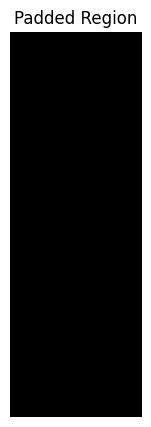

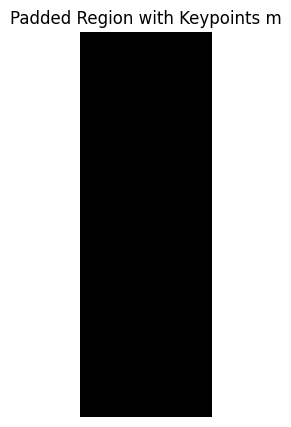

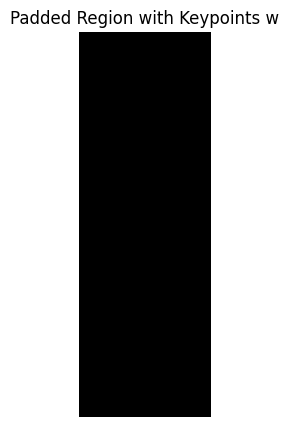

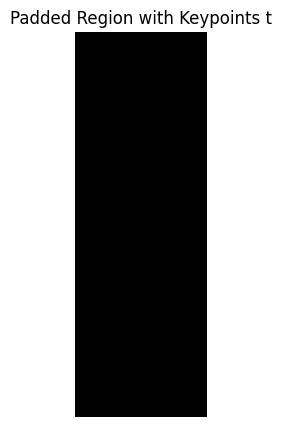

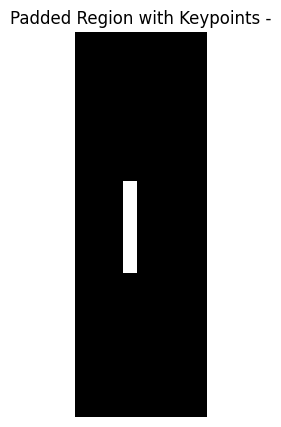

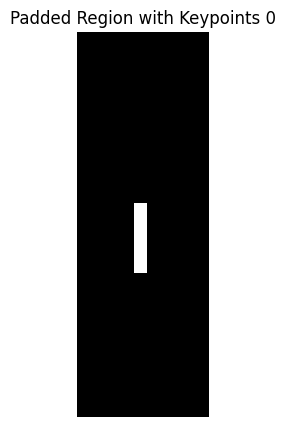

In [ ]:
# Kernel for dilation
kernel = np.ones((3, 1), np.uint8)
borderType = cv2.BORDER_CONSTANT

# Function to pad the image
def pad(src):
    top = int(0.05 * src.shape[0])  # shape[0] = rows
    bottom = top
    left = int(0.15 * src.shape[1])  # shape[1] = cols
    right = left
    des = cv2.copyMakeBorder(src, top, bottom, left + 1, right, borderType, None, 255)
    return cv2.bitwise_not(des)

# BRISK Feature Detector
def getBRISKDescriptors(image):
    brisk = cv2.BRISK_create()
    keypoints, descriptors = brisk.detectAndCompute(image, None)
    return keypoints, descriptors

# Process images
x = []
y = []
images = ["/content/cleaned_images/1imwt-0.png"]  # Example image paths, replace with actual paths
for image_path in images:
    im = cv2.imread(image_path, 0)

    # Preprocess the image
    threshold = cv2.adaptiveThreshold(im, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 199, 5)
    erosion = cv2.dilate(threshold, kernel, iterations=2)

    # Pad and segment the image into regions
    s = os.path.basename(image_path)  # Get the file name from the path
    for i in range(5):
        padded_region = pad(erosion[:, (30 + 23 * i):(30 + 23 * (i + 1))])

        # Apply BRISK on the padded region
        keypoints, descriptors = getBRISKDescriptors(padded_region)

        # Store the padded region and corresponding label
        x.append(padded_region)
        y.append(s[-9 + i])  # Assuming the labels are the last 5 characters of the filename

# Display an example padded region with BRISK keypoints
plt.figure(figsize=(10, 5))
plt.imshow(x[0], cmap='gray')
plt.title("Padded Region")
plt.axis('off')
plt.show()

# Optionally visualize the keypoints
for i, region in enumerate(x):
    keypoints, _ = getBRISKDescriptors(region)
    img_with_keypoints = cv2.drawKeypoints(region, keypoints, None, color=(0, 255, 0), flags=0)

    plt.figure(figsize=(10, 5))
    plt.imshow(img_with_keypoints, cmap='gray')
    plt.title(f"Padded Region with Keypoints {y[i]}")
    plt.axis('off')
    plt.show()

# WaterShed Algorithm

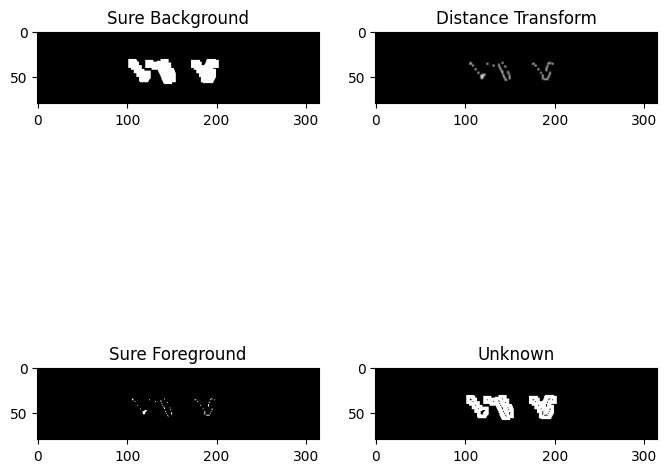

In [ ]:
import cv2
import numpy as np
from IPython.display import Image, display
from matplotlib import pyplot as plt

img = cv2.imread("/content/Dataset/Dataset/Train/Clean/1vbc15z-0.png")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Threshold Processing
ret, bin_img = cv2.threshold(gray,
                             100, 255,
                             cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# noise removal
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
bin_img = cv2.morphologyEx(bin_img,
                           cv2.MORPH_OPEN,
                           kernel,
                           iterations=1)

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
# sure background area
sure_bg = cv2.dilate(bin_img, kernel, iterations=3)
axes[0, 0].imshow(sure_bg, cmap='gray')
axes[0, 0].set_title('Sure Background')

# Distance transform
dist = cv2.distanceTransform(bin_img, cv2.DIST_L2, 5)
axes[0, 1].imshow(dist, cmap='gray')
axes[0, 1].set_title('Distance Transform')

#foreground area
ret, sure_fg = cv2.threshold(dist, 0.5 * dist.max(), 255, cv2.THRESH_BINARY)
sure_fg = sure_fg.astype(np.uint8)
axes[1, 0].imshow(sure_fg, cmap='gray')
axes[1, 0].set_title('Sure Foreground')

# unknown area
unknown = cv2.subtract(sure_bg, sure_fg)
axes[1, 1].imshow(unknown, cmap='gray')
axes[1, 1].set_title('Unknown')

plt.show()

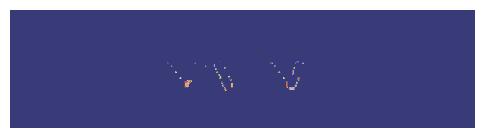

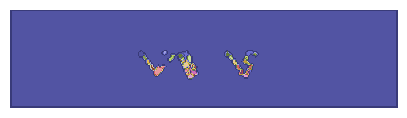

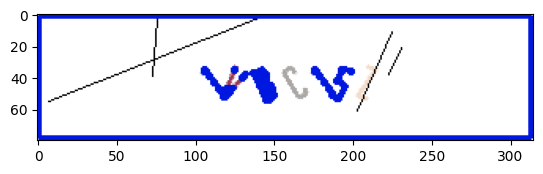

In [ ]:
# Marker labelling
# sure foreground
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that background is not 0, but 1
markers += 1
# mark the region of unknown with zero
markers[unknown == 255] = 0

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(markers, cmap="tab20b")
ax.axis('off')
plt.show()

# watershed Algorithm
markers = cv2.watershed(img, markers)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(markers, cmap="tab20b")
ax.axis('off')
plt.show()


labels = np.unique(markers)

coins = []
for label in labels[2:]:

# Create a binary image in which only the area of the label is in the foreground
#and the rest of the image is in the background
    target = np.where(markers == label, 255, 0).astype(np.uint8)

  # Perform contour extraction on the created binary image
    contours, hierarchy = cv2.findContours(
        target, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    coins.append(contours[0])

# Draw the outline
img = cv2.drawContours(img, coins, -1, color=(0, 23, 223), thickness=2)
plt.imshow(img)

# Test Code

In [ ]:
#######################TEST CODE###########################
# Create a directory for saving character images if it doesn't exist
output_char_folder = "extracted_chars"
if not os.path.exists(output_char_folder):
    os.makedirs(output_char_folder)

size_threshold = 3.0
mismatch_count = 0
mismatched_images = []  # To store mismatched images for display

def is_size_consistent(roi_size, ref_size, threshold=0.1):
    width_diff = abs(roi_size[1] - ref_size[1]) / ref_size[1]
    height_diff = abs(roi_size[0] - ref_size[0]) / ref_size[0]

    return width_diff <= threshold and height_diff <= threshold

# Function to save ROIs if the count matches the label length
def save_rois_if_match(image_path, label, rois):
    global mismatch_count  # Declare mismatch_count as global
    # Check if number of ROIs matches the length of the label
    if len(rois) == len(label):
        saved_paths = []
        # Check for size consistency
        ref_size = rois[0].shape if len(rois) > 0 else None
        size_inconsistent = False

        for roi in rois:
            if not is_size_consistent(roi.shape, ref_size, size_threshold):
                size_inconsistent = True
                break

        if not size_inconsistent:
            # Save the ROIs if sizes are consistent and count matches the label
            for i, roi in enumerate(rois):
                # Construct the file name and save the ROI
                roi_file_name = f"{os.path.basename(image_path).split('.')[0]}_char_{i + 1}.png"
                roi_path = os.path.join(output_char_folder, roi_file_name)
                cv2.imwrite(roi_path, roi)
                saved_paths.append(roi_path)
            return saved_paths
        else:
            # Size inconsistency found
            print(f"Size inconsistency for {image_path}: {len(rois)} ROIs, but one or more ROIs have different sizes.")
            mismatch_count += 1
            mismatched_images.append((image_path, rois))
            return []
        # for i, roi in enumerate(rois):
        #     # Construct the file name and save the ROI
        #     roi_file_name = f"{os.path.basename(image_path).split('.')[0]}_char_{i + 1}.png"
        #     roi_path = os.path.join(output_char_folder, roi_file_name)
        #     cv2.imwrite(roi_path, roi)
        #     saved_paths.append(roi_path)
        # return saved_paths

    else:
        print(f"Mismatch for {image_path}: {len(rois)} ROIs but label length is {len(label)}.")
        mismatch_count += 1
        mismatched_images.append((image_path, rois))
        return []

# Creating a new DataFrame to store saved image paths
saved_images_data = []

# Iterate through the DataFrame to process each image
print('-----POTENTIAL MISMATCH-----')
for idx, row in df.iterrows():
    image_path = row['processed_images']
    label = row['label']  # Assuming you have a 'label' column in the DataFrame
    contours_image, rois = extract_rois(image_path)

    # Save ROIs if they match the label length
    saved_paths = save_rois_if_match(image_path, label, rois)

    # Append the results to the new DataFrame
    if saved_paths:
        saved_images_data.append({
            'image_path': image_path,
            'label': label,
            'saved_char_paths': saved_paths
        })

print(f'TOTAL MISMATCH COUNT: {mismatch_count}')
if mismatched_images:
    print("Displaying mismatched images:")
    for image_path, rois in mismatched_images:
        img = cv2.imread(image_path)
        if img is not None:
            if rois:
                plt.figure(figsize=(12, 6))
                for i, roi in enumerate(rois):
                    plt.subplot(1, len(rois), i + 1)
                    plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
                    plt.title(f"ROI {i + 1}\n{roi.size}")
                    plt.axis('off')
                plt.show()
        else:
            print(f"Could not load image: {image_path}")

# Colour Based Segmentation

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

img = cv2.imread("/content/0hox6-0.png")

Most frequent color: (233, 237, 234) with frequency 929
Threshold: 185.8
Frequent colors (above threshold):
Color: (233, 237, 234), Frequency: 929
Color: (200, 209, 209), Frequency: 350
Color: (183, 189, 189), Frequency: 578
Color: (162, 165, 164), Frequency: 414
Color: (193, 234, 192), Frequency: 245
Color: (152, 205, 124), Frequency: 243


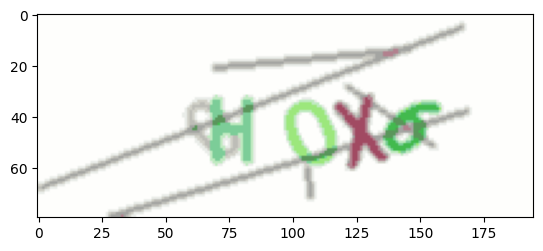

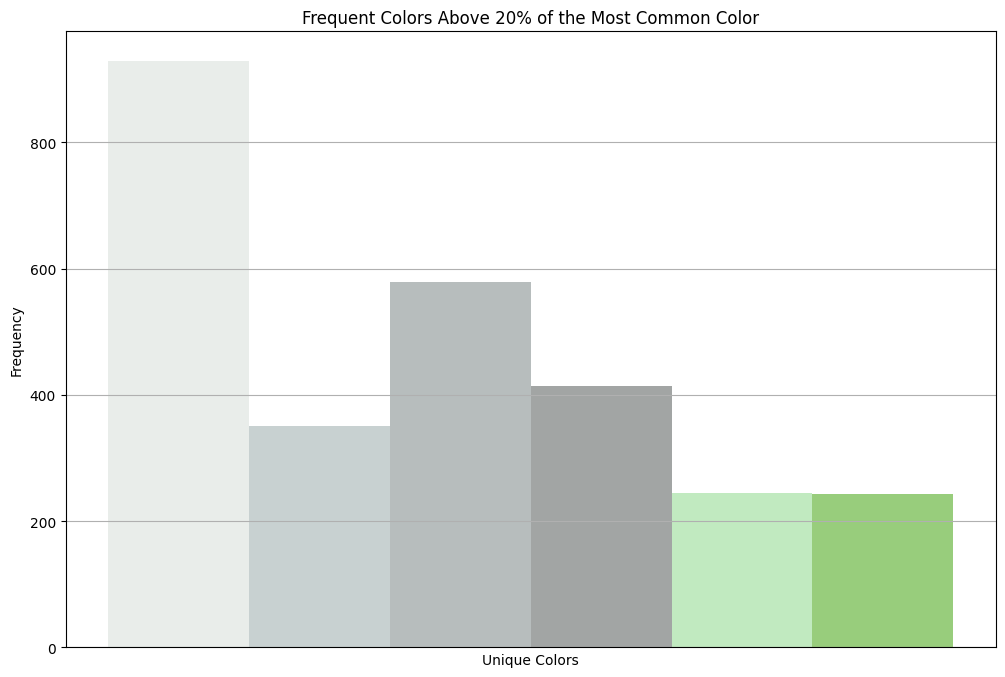

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def quantize_colors(image, n_colors=12, blur_kernel_size=(5, 5)):
    """ Reduce the number of colors in the image using K-means clustering. """
    smoothed_image = cv2.GaussianBlur(image, blur_kernel_size, 0)

    lab_image = cv2.cvtColor(smoothed_image, cv2.COLOR_BGR2Lab)

    # Reshape the image to a 2D array of pixels
    pixels = lab_image.reshape(-1, 3)

    # Convert to float for K-means
    pixels = np.float32(pixels)

    # Define criteria and apply K-means
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(pixels, n_colors, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Convert centers to uint8
    centers = np.uint8(centers)

    # Map the labels to the quantized colors
    quantized_image = centers[labels.flatten()]
    quantized_image = cv2.cvtColor(quantized_image.reshape(image.shape), cv2.COLOR_Lab2BGR)

    return quantized_image

def get_frequent_colors_with_threshold(image, threshold_ratio=0.5, n_colors=12):
    # Reduce the color range of the image
    image = quantize_colors(image, n_colors)
    plt.imshow(image)

    # Convert the image from BGR to RGB format
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Step 2: Reshape the image to a 2D array of pixels
    pixels = image_rgb.reshape(-1, 3)

    # Step 3: Filter out white pixels (where RGB is [255, 255, 255])
    non_white_pixels = [tuple(pixel) for pixel in pixels if not (pixel[0] >= 250 and pixel[1] >= 250 and pixel[2] >= 250)]

    # Step 4: Count the frequency of each unique color (as tuples)
    color_counts = Counter(non_white_pixels)

    # Step 5: Find the most frequent color and its frequency
    most_common_color, max_frequency = color_counts.most_common(1)[0]

    # Step 6: Apply a threshold relative to the frequency of the most common color
    threshold = max_frequency * threshold_ratio

    # Filter out colors that occur less frequently than the threshold
    frequent_colors = {color: freq for color, freq in color_counts.items() if freq >= threshold}

    # Step 7: Display the most frequent colors
    print(f"Most frequent color: {most_common_color} with frequency {max_frequency}")
    print(f"Threshold: {threshold}")
    print("Frequent colors (above threshold):")
    for color, freq in frequent_colors.items():
        print(f"Color: {color}, Frequency: {freq}")

    # Step 8: Plot the histogram of frequent colors
    colors = np.array(list(frequent_colors.keys()))
    frequencies = np.array(list(frequent_colors.values()))

    # Normalize the color values to [0, 1] for displaying in matplotlib
    normalized_colors = colors / 255.0

    # Plot the histogram
    plt.figure(figsize=(12, 8))
    plt.bar(range(len(frequencies)), frequencies, color=normalized_colors, width=1.0)

    # Configure plot
    plt.title(f'Frequent Colors Above {threshold_ratio*100:.0f}% of the Most Common Color')
    plt.xlabel('Unique Colors')
    plt.ylabel('Frequency')
    plt.xticks([])  # Remove x-axis ticks to focus on color distribution
    plt.grid()

    # Show the plot
    plt.show()

    return frequent_colors, image_rgb

# Example usage
frequent_colors, processed_image = get_frequent_colors_with_threshold(img, threshold_ratio=0.2, n_colors=12)


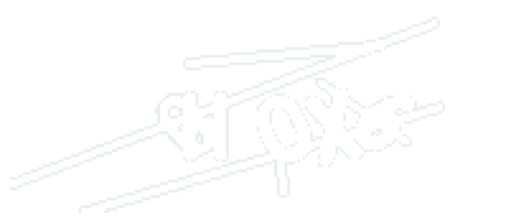

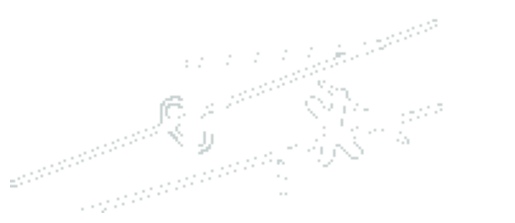

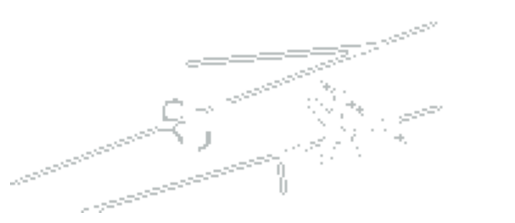

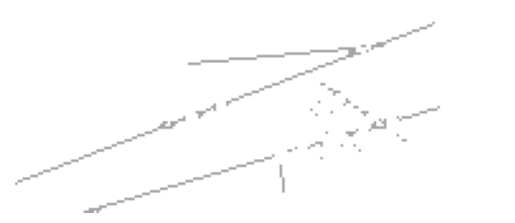

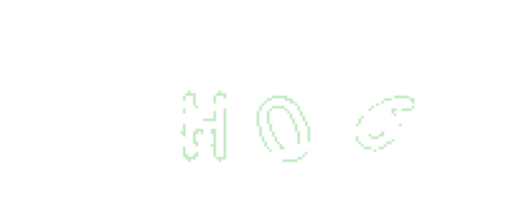

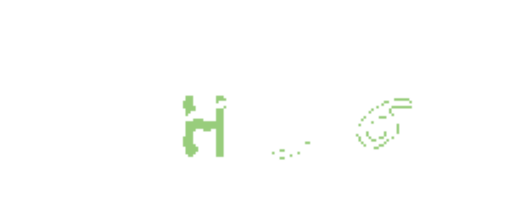

In [ ]:
def create_individual_images_for_each_color(image, frequent_colors):
    images = []
    height, width, _ = image.shape

    # Step 9: Create a separate image for each frequent color
    for i, (color, freq) in enumerate(frequent_colors.items()):
        # Create a black image with the same size as the original
        color_image = np.ones((height, width, 3), dtype=np.uint8) * 255

        # Fill the new image with only the pixels matching the current color
        for y in range(height):
            for x in range(width):
                pixel_color = tuple(image[y, x])
                if pixel_color == color:
                    color_image[y, x] = color

        images.append(color_image)

    return images

char_images = create_individual_images_for_each_color(processed_image, frequent_colors)
for image in char_images:
    plt.imshow(image)
    plt.axis('off')
    plt.show()

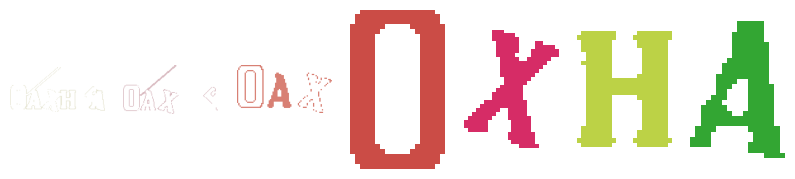

In [ ]:
def save_colored_character(image):
    # Convert the image from BGR to RGB format
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Get the coordinates of the non-black pixels
    non_black_pixels = np.where((rgb_image != [255, 255, 255]).any(axis=-1))

    # Check if we have any colored pixels
    if len(non_black_pixels[0]) == 0:
        print("No colored pixels found.")
        return

    # Get the bounding box of the colored pixels
    min_x = np.min(non_black_pixels[1])
    max_x = np.max(non_black_pixels[1])
    min_y = np.min(non_black_pixels[0])
    max_y = np.max(non_black_pixels[0])

    # Extract the region of interest (ROI) containing the character
    character_image = rgb_image[min_y:max_y + 1, min_x:max_x + 1]

    # Create a new image with a black background and the same size as the bounding box
    new_image = np.zeros((max_y - min_y + 1, max_x - min_x + 1, 3), dtype=np.uint8)

    # Fill the new image with the colored pixels from the character image
    new_image[:character_image.shape[0], :character_image.shape[1]] = character_image

    return new_image


cropped_char_images = []

for image in char_images:
     cropped_char_images.append(save_colored_character(image))

plt.figure(figsize=(10, 5))
for i, image in enumerate(cropped_char_images):
    plt.subplot(1, len(cropped_char_images), i+1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
plt.show()

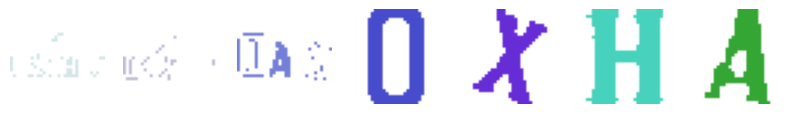

In [ ]:
def resize_and_pad(image, target_size=(32, 32)):
    height, width = image.shape[:2]

    # Calculate the scaling factor and new dimensions
    scale = min(target_size[0] / width, target_size[1] / height)
    new_size = (int(width * scale), int(height * scale))

    # Resize the image
    # Use INTER_NEAREST interpolation for no anti-aliasing
    resized_image = cv2.resize(image, new_size, interpolation=cv2.INTER_NEAREST)

    # Create a new image with a white background
    padded_image = np.ones((target_size[1], target_size[0], 3), dtype=np.uint8) * 255  # White background

    # Calculate padding offsets
    pad_x = (target_size[0] - new_size[0]) // 2
    pad_y = (target_size[1] - new_size[1]) // 2

    # Place the resized image in the center of the padded image
    padded_image[pad_y:pad_y + new_size[1], pad_x:pad_x + new_size[0]] = resized_image

    return padded_image

padded_images = []

for image in cropped_char_images:
    padded_images.append(resize_and_pad(image))

plt.figure(figsize=(10, 5))
for i, image in enumerate(padded_images):
    plt.subplot(1, len(padded_images), i+1)
    plt.imshow(image)
    plt.axis('off')
plt.show()

Evaluating color segmentation

In [ ]:
import cv2
import numpy as np
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple
import time

class CaptchaEvaluator:
    def __init__(self):
        self.metrics = {}

    def evaluate_color_quantization(self, original_image: np.ndarray,
                                  quantized_image: np.ndarray,
                                  n_colors: int) -> Dict:
        """Evaluate the effectiveness of color quantization"""
        # Time the operation
        start_time = time.time()
        quantized_image = quantize_colors(original_image, n_colors)
        processing_time = time.time() - start_time

        # Calculate color reduction ratio
        original_colors = len(np.unique(original_image.reshape(-1, 3), axis=0))
        quantized_colors = len(np.unique(quantized_image.reshape(-1, 3), axis=0))
        color_reduction_ratio = quantized_colors / original_colors

        # Calculate color clustering quality using silhouette score
        pixels = quantized_image.reshape(-1, 3)
        labels = np.zeros(pixels.shape[0])
        for i, unique_color in enumerate(np.unique(pixels, axis=0)):
            mask = np.all(pixels == unique_color, axis=1)
            labels[mask] = i

        try:
            silhouette = silhouette_score(pixels, labels)
        except:
            silhouette = 0

        # Calculate MSE between original and quantized image
        mse = np.mean((original_image - quantized_image) ** 2)

        return {
            'processing_time': processing_time,
            'color_reduction_ratio': color_reduction_ratio,
            'clustering_quality': silhouette,
            'mse': mse
        }

    def evaluate_color_extraction(self, image: np.ndarray,
                                frequent_colors: Dict,
                                threshold_ratio: float) -> Dict:
        """Evaluate the effectiveness of frequent color extraction"""
        start_time = time.time()

        # Calculate coverage ratio (how much of the non-background image is captured)
        non_white_pixels = np.sum(~np.all(image == [255, 255, 255], axis=2))
        pixels_captured = sum(freq for freq in frequent_colors.values())
        coverage_ratio = pixels_captured / non_white_pixels if non_white_pixels > 0 else 0

        # Calculate color separation (average distance between frequent colors)
        colors = np.array(list(frequent_colors.keys()))
        if len(colors) > 1:
            color_distances = []
            for i in range(len(colors)):
                for j in range(i + 1, len(colors)):
                    distance = np.linalg.norm(colors[i] - colors[j])
                    color_distances.append(distance)
            avg_color_separation = np.mean(color_distances)
        else:
            avg_color_separation = 0

        return {
            'processing_time': time.time() - start_time,
            'coverage_ratio': coverage_ratio,
            'color_separation': avg_color_separation,
            'num_colors_found': len(frequent_colors)
        }

    def evaluate_character_extraction(self, char_images: List[np.ndarray]) -> Dict:
        """Evaluate the effectiveness of character extraction"""
        start_time = time.time()

        metrics = {
            'processing_time': time.time() - start_time,
            'num_characters': len(char_images),
            'avg_aspect_ratio': 0,
            'size_consistency': 0,
            'separation_quality': 0
        }

        if not char_images:
            return metrics

        # Calculate aspect ratios and sizes
        aspect_ratios = []
        sizes = []
        for img in char_images:
            if img is not None:
                h, w = img.shape[:2]
                aspect_ratios.append(w/h if h > 0 else 0)
                sizes.append(h * w)

        if aspect_ratios:
            metrics['avg_aspect_ratio'] = np.mean(aspect_ratios)
            metrics['size_consistency'] = 1 - (np.std(sizes) / np.mean(sizes)) if np.mean(sizes) > 0 else 0

        return metrics

    def visualize_evaluation(self, metrics: Dict):
        """Visualize the evaluation metrics"""
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Color Quantization Metrics
        axes[0].bar(['Reduction Ratio', 'Clustering Quality', 'MSE (scaled)'],
                   [metrics['quantization']['color_reduction_ratio'],
                    metrics['quantization']['clustering_quality'],
                    metrics['quantization']['mse'] / 1000])
        axes[0].set_title('Color Quantization Metrics')

        # Color Extraction Metrics
        axes[1].bar(['Coverage Ratio', 'Color Separation (scaled)', 'Colors Found (scaled)'],
                   [metrics['extraction']['coverage_ratio'],
                    metrics['extraction']['color_separation'] / 255,
                    metrics['extraction']['num_colors_found'] / 10])
        axes[1].set_title('Color Extraction Metrics')

        # Character Extraction Metrics
        axes[2].bar(['Num Characters (scaled)', 'Aspect Ratio', 'Size Consistency'],
                   [metrics['char_extraction']['num_characters'] / 10,
                    metrics['char_extraction']['avg_aspect_ratio'],
                    metrics['char_extraction']['separation_quality']])
        axes[2].set_title('Character Extraction Metrics')

        plt.tight_layout()
        plt.show()

        # Print processing times
        print("\nProcessing Times:")
        print(f"Color Quantization: {metrics['quantization']['processing_time']:.3f}s")
        print(f"Color Extraction: {metrics['extraction']['processing_time']:.3f}s")
        print(f"Character Extraction: {metrics['char_extraction']['processing_time']:.3f}s")

def evaluate_pipeline(image_path: str, n_colors: int = 12, threshold_ratio: float = 0.2):
    """Complete evaluation of the CAPTCHA segmentation pipeline"""
    evaluator = CaptchaEvaluator()
    image = cv2.imread(image_path)

    # Evaluate each step
    quant_metrics = evaluator.evaluate_color_quantization(image, None, n_colors)
    frequent_colors, processed_image = get_frequent_colors_with_threshold(image, threshold_ratio, n_colors)
    extraction_metrics = evaluator.evaluate_color_extraction(processed_image, frequent_colors, threshold_ratio)
    char_images = create_individual_images_for_each_color(processed_image, frequent_colors)
    char_metrics = evaluator.evaluate_character_extraction(char_images)

    # Combine metrics
    all_metrics = {
        'quantization': quant_metrics,
        'extraction': extraction_metrics,
        'char_extraction': char_metrics
    }

    # Visualize results
    evaluator.visualize_evaluation(all_metrics)

    return all_metrics

Most frequent color: (237, 232, 227) with frequency 562
Threshold: 112.4
Frequent colors (above threshold):
Color: (237, 232, 227), Frequency: 562
Color: (221, 186, 187), Frequency: 487
Color: (215, 127, 115), Frequency: 484
Color: (203, 76, 70), Frequency: 370
Color: (204, 227, 158), Frequency: 224
Color: (212, 42, 101), Frequency: 265
Color: (182, 208, 55), Frequency: 322
Color: (64, 167, 65), Frequency: 283


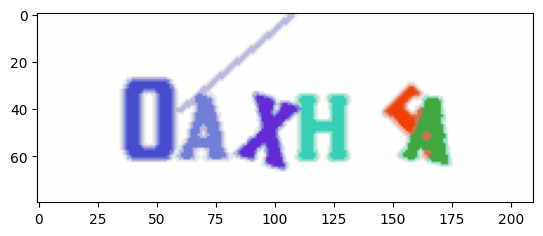

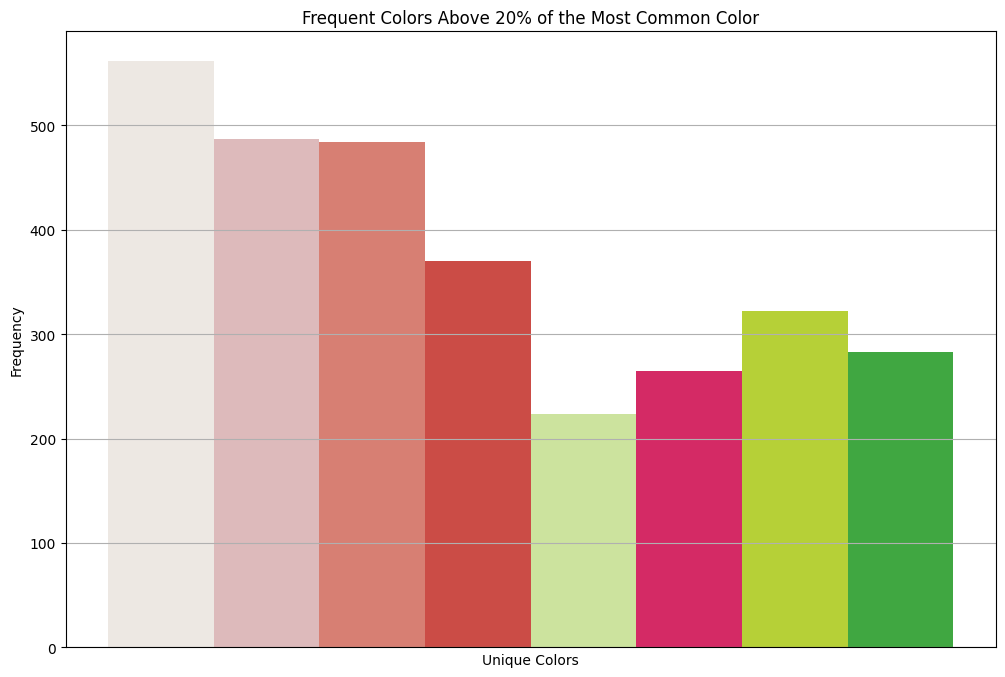

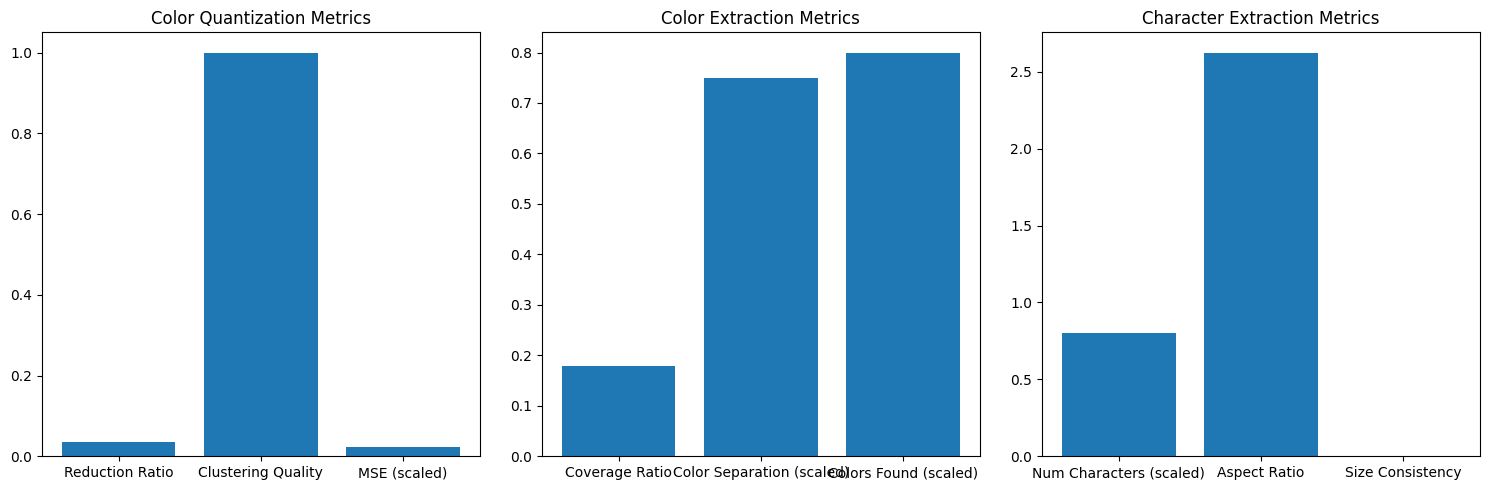


Processing Times:
Color Quantization: 0.795s
Color Extraction: 0.001s
Character Extraction: 0.000s

Quantization Metrics:
{'processing_time': 0.7950410842895508, 'color_reduction_ratio': 0.036585365853658534, 'clustering_quality': 1.0, 'mse': 22.457579365079365}

Extraction Metrics:
{'processing_time': 0.001392364501953125, 'coverage_ratio': 0.17839285714285713, 'color_separation': 190.95893765701112, 'num_colors_found': 8}

Character Extraction Metrics:
{'processing_time': 7.152557373046875e-07, 'num_characters': 8, 'avg_aspect_ratio': 2.625, 'size_consistency': 1.0, 'separation_quality': 0}


In [ ]:
metrics = evaluate_pipeline('/content/0axhfa-0.png')

# Access all metrics
quantization_metrics = metrics['quantization']
extraction_metrics = metrics['extraction']
char_extraction_metrics = metrics['char_extraction']

print("\nQuantization Metrics:")
print(quantization_metrics)

print("\nExtraction Metrics:")
print(extraction_metrics)

print("\nCharacter Extraction Metrics:")
print(char_extraction_metrics)

Most frequent color: (207, 64, 84) with frequency 626
Threshold: 125.2
Frequent colors (above threshold):
Color: (237, 227, 229), Frequency: 426
Color: (221, 186, 189), Frequency: 502
Color: (215, 127, 115), Frequency: 493
Color: (207, 64, 84), Frequency: 626
Color: (217, 234, 179), Frequency: 260
Color: (183, 208, 58), Frequency: 336
Color: (54, 164, 50), Frequency: 219


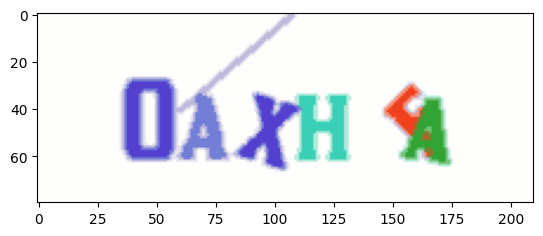

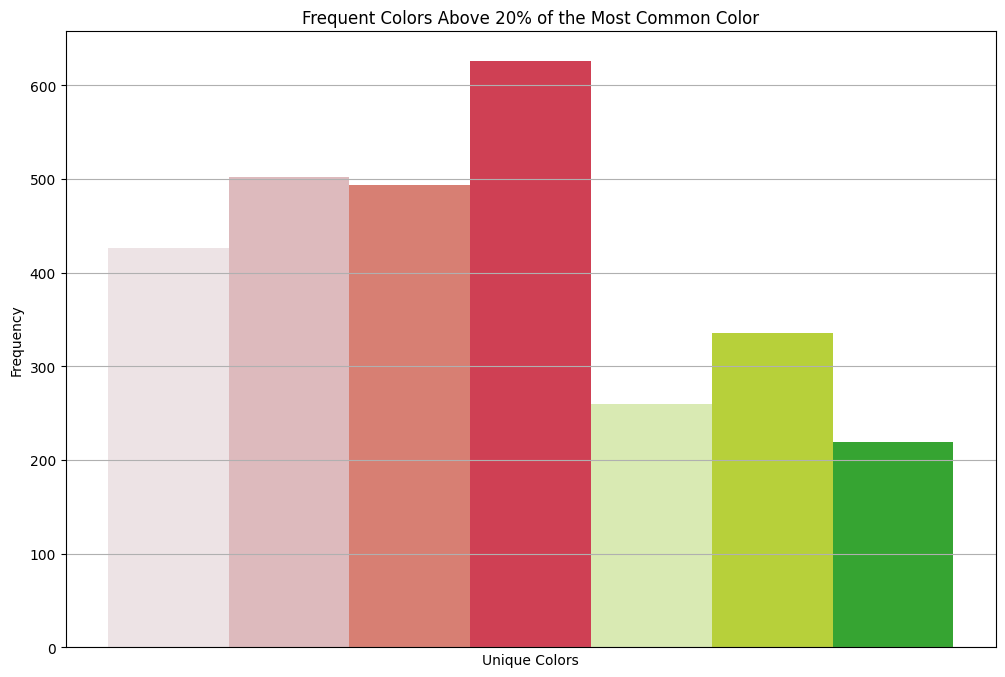

Original colors: 7
Merged colors: 7


In [ ]:
def improve_color_extraction(image, threshold_ratio=0.2):
    """Modified color extraction with connected component analysis"""
    from scipy.ndimage import label

    # Get initial colors
    frequent_colors, processed_image = get_frequent_colors_with_threshold(image, threshold_ratio)

    # For each color, analyze connected components
    refined_colors = {}
    for color in frequent_colors:
        # Create binary mask for this color
        mask = np.all(processed_image == color, axis=2)

        # Label connected components
        labeled_array, num_features = label(mask)

        # Only keep colors that form significant connected components
        if num_features > 0:
            component_sizes = [np.sum(labeled_array == i) for i in range(1, num_features + 1)]
            if max(component_sizes) > 50:  # Minimum size threshold
                refined_colors[color] = frequent_colors[color]

    return refined_colors

def merge_similar_colors(frequent_colors_tuple, similarity_threshold=30):
    """Merge colors that are too similar

    Args:
        frequent_colors_tuple: Tuple of (frequent_colors_dict, processed_image)
        similarity_threshold: Maximum RGB distance to consider colors similar

    Returns:
        Dict of merged colors and their frequencies
    """
    # Extract the frequent_colors dictionary from the tuple
    frequent_colors, _ = frequent_colors_tuple

    colors = list(frequent_colors.keys())
    merged_colors = {}

    while colors:
        current_color = colors.pop(0)
        current_freq = frequent_colors[current_color]

        # Find similar colors
        similar_colors = []
        for color in colors[:]:
            distance = np.linalg.norm(np.array(current_color) - np.array(color))
            if distance < similarity_threshold:
                similar_colors.append(color)
                colors.remove(color)

        # Merge frequencies
        total_freq = current_freq + sum(frequent_colors[c] for c in similar_colors)
        merged_colors[current_color] = total_freq

    return merged_colors

def normalize_character_extraction(char_image, target_aspect=1.5):
    """Normalize extracted characters to prevent elongated segments"""
    height, width = char_image.shape[:2]
    current_aspect = width / height

    if current_aspect > target_aspect:
        # Split horizontally if too wide
        split_point = width // 2
        left = char_image[:, :split_point]
        right = char_image[:, split_point:]
        return [left, right]

    return [char_image]

def improved_segmentation_pipeline(image):
    # Initial color quantization
    quantized = quantize_colors(image)

    # Get frequent colors (returns tuple)
    frequent_colors_tuple = get_frequent_colors_with_threshold(quantized)

    # Merge similar colors
    merged_colors = merge_similar_colors(frequent_colors_tuple)

    # Use merged colors for extraction
    char_images = create_individual_images_for_each_color(quantized, merged_colors)

    return char_images

# Example usage
frequent_colors_tuple = get_frequent_colors_with_threshold(img, threshold_ratio=0.2, n_colors=12)
merged_colors = merge_similar_colors(frequent_colors_tuple)
print(f"Original colors: {len(frequent_colors_tuple[0])}")
print(f"Merged colors: {len(merged_colors)}")


Original colors: 7
Improved merged colors: 5


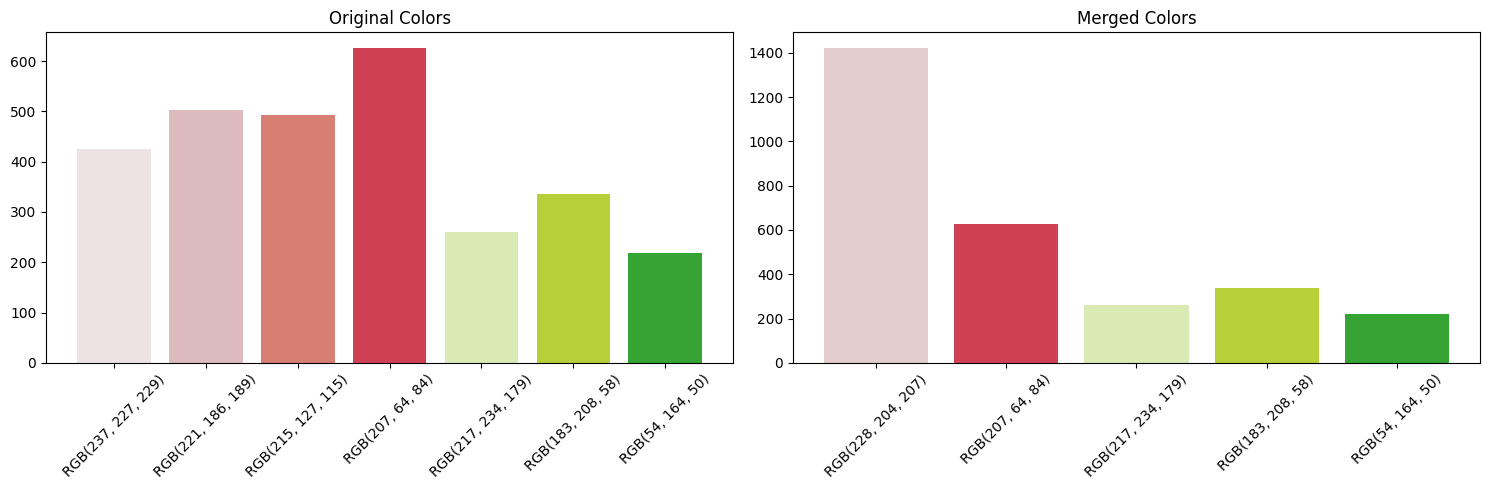

In [ ]:
def merge_similar_colors_improved(frequent_colors_tuple, min_threshold=70, max_threshold=100):
    """Merge colors with a two-level threshold approach"""
    frequent_colors, processed_image = frequent_colors_tuple
    colors = list(frequent_colors.keys())
    merged_colors = {}
    processed = set()

    # Get all pairwise distances
    distances = analyze_color_distances(frequent_colors_tuple)

    # First pass: merge very similar colors (distance < min_threshold)
    for color1, color2, distance in distances:
        if distance > min_threshold:
            continue
        if color1 not in processed and color2 not in processed:
            # Merge using weighted average based on frequency
            freq1 = frequent_colors[color1]
            freq2 = frequent_colors[color2]
            total_freq = freq1 + freq2

            # Calculate weighted average color
            merged_color = tuple(int((c1 * freq1 + c2 * freq2) / total_freq)
                               for c1, c2 in zip(color1, color2))

            merged_colors[merged_color] = total_freq
            processed.add(color1)
            processed.add(color2)

    # Second pass: consider moderately similar colors
    for color1, color2, distance in distances:
        if min_threshold <= distance <= max_threshold:
            # Only merge if one color isn't already processed
            if color1 not in processed and color2 in processed:
                target = color2
                to_merge = color1
            elif color2 not in processed and color1 in processed:
                target = color1
                to_merge = color2
            else:
                continue

            # Find the merged color this target was merged into
            for merged_color in merged_colors:
                if np.linalg.norm(np.array(merged_color) - np.array(target)) < min_threshold:
                    merged_colors[merged_color] += frequent_colors[to_merge]
                    processed.add(to_merge)
                    break

    # Add remaining unprocessed colors
    for color in colors:
        if color not in processed:
            merged_colors[color] = frequent_colors[color]

    return merged_colors

# Test improved merging
improved_merged_colors = merge_similar_colors_improved(frequent_colors_tuple)
print(f"\nOriginal colors: {len(frequent_colors_tuple[0])}")
print(f"Improved merged colors: {len(improved_merged_colors)}")

# Visualize results
def visualize_improved_colors(original_colors, merged_colors):
    """Visualize original and merged colors with RGB values"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Original colors
    colors1 = list(original_colors.keys())
    freqs1 = list(original_colors.values())
    ax1.bar(range(len(colors1)), freqs1, color=[np.array(c)/255 for c in colors1])
    ax1.set_title('Original Colors')
    ax1.set_xticks(range(len(colors1)))
    ax1.set_xticklabels([f'RGB{c}' for c in colors1], rotation=45)

    # Merged colors
    colors2 = list(merged_colors.keys())
    freqs2 = list(merged_colors.values())
    ax2.bar(range(len(colors2)), freqs2, color=[np.array(c)/255 for c in colors2])
    ax2.set_title('Merged Colors')
    ax2.set_xticks(range(len(colors2)))
    ax2.set_xticklabels([f'RGB{c}' for c in colors2], rotation=45)

    plt.tight_layout()
    plt.show()

visualize_improved_colors(frequent_colors_tuple[0], improved_merged_colors)

# Model

In [ ]:
import torch
import torch.nn as nn

class NeuralNet(nn.Module):
    def __init__(self, input_channels, input_height, input_width):
        super().__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1)  # 32 filters
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # 64 filters
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  # 128 filters
        self.batch_norm3 = nn.BatchNorm2d(128)  # Batch normalization after the third conv layer

        # Fully connected layers
        self.flatten = nn.Flatten()  # Flattening the output for the dense layer

        self.fc1 = nn.Linear(128 * (input_height // 4) * (input_width // 4), 256)  # Adjusting for input size after pooling
        self.relu = nn.ReLU()

        self.dropout = nn.Dropout(0.5)  # Optional Dropout layer

        self.fc2 = nn.Linear(256, 36)  # Output layer for 36 classes

    def forward(self, x):
        # Forward pass through the convolutional layers
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.batch_norm3(x)

        # Flatten and pass through dense layers
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)  # Output layer

        return x

def train_model(loader, model):
    optimiser = torch.optim.Adam(model.parameters(), lr=0.0001)
    loss_fn = nn.CrossEntropyLoss()

    epoch_losses = []
    for i in range(15):
        epoch_loss = 0

        for idx, data in enumerate(loader):
            x, y = data
            # Ensure x has the correct shape for Conv2D (batch_size, channels, height, width)
            if x.dim() == 3:  # If input is (batch_size, height, width)
                x = x.unsqueeze(1)  # Add channels dimension

            optimiser.zero_grad()
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimiser.step()
            epoch_loss += loss.item()

        epoch_loss = epoch_loss / len(loader)
        epoch_losses.append(epoch_loss)
        print("Epoch: {}, Loss: {}".format(i + 1, epoch_loss))

    return model, epoch_losses


In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CharImageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.char_image_path[idx]
        label = self.df.label[idx]

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img is not None:
            if self.transform:
                img = self.transform(img)

            return img, label
        else:
            raise FileNotFoundError(f"Image not found: {img_path}")

# Transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

dataset = CharImageDataset(character_df, transform=transform)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

In [ ]:
input_channels = 1
input_height = 32
input_width = 32
model = NeuralNet(input_channels, input_height, input_width)
model, losses = train_model(loader, model)

# Plot Losses
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

TypeError: cross_entropy_loss(): argument 'target' (position 2) must be Tensor, not tuple